# Análisis de Emisiones de CO₂ y su Relación con Indicadores Económicos

Este notebook analiza las tendencias globales de emisiones de CO₂ y su relación con indicadores económicos como el PIB, explorando patrones y correlaciones a nivel mundial y regional.

## Configuración del Entorno

Importamos las bibliotecas necesarias y establecemos la conexión con la base de datos.

In [17]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
import geopandas as gpd
from dotenv import load_dotenv
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import pycountry
# from scipy import stats

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Cargar variables de entorno y conectar a la base de datos
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

# Funciones de formato para ejes
def formato_millones(x, pos):
    return f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}k'

def formato_miles_millones(x, pos):
    return f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.1f}M'

## 0. Relacion de emisiones de CO2 - PIB en los paises del mundo

En los siguientes mapas regionales podemos observar como es la relacion entre las emisiones de co2 producidas por cada pais en comparacion a su producto interior bruto

C:\Users\david\AppData\Local\Temp\ipykernel_14856\4292558473.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


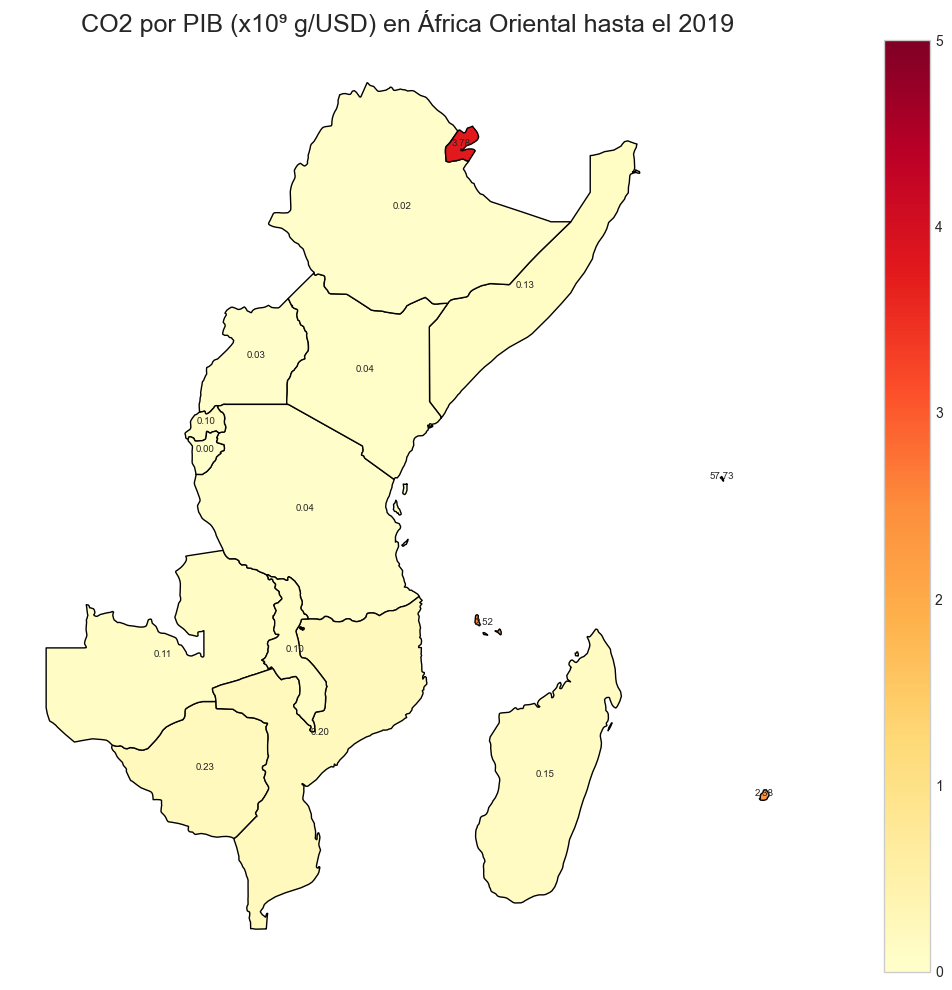

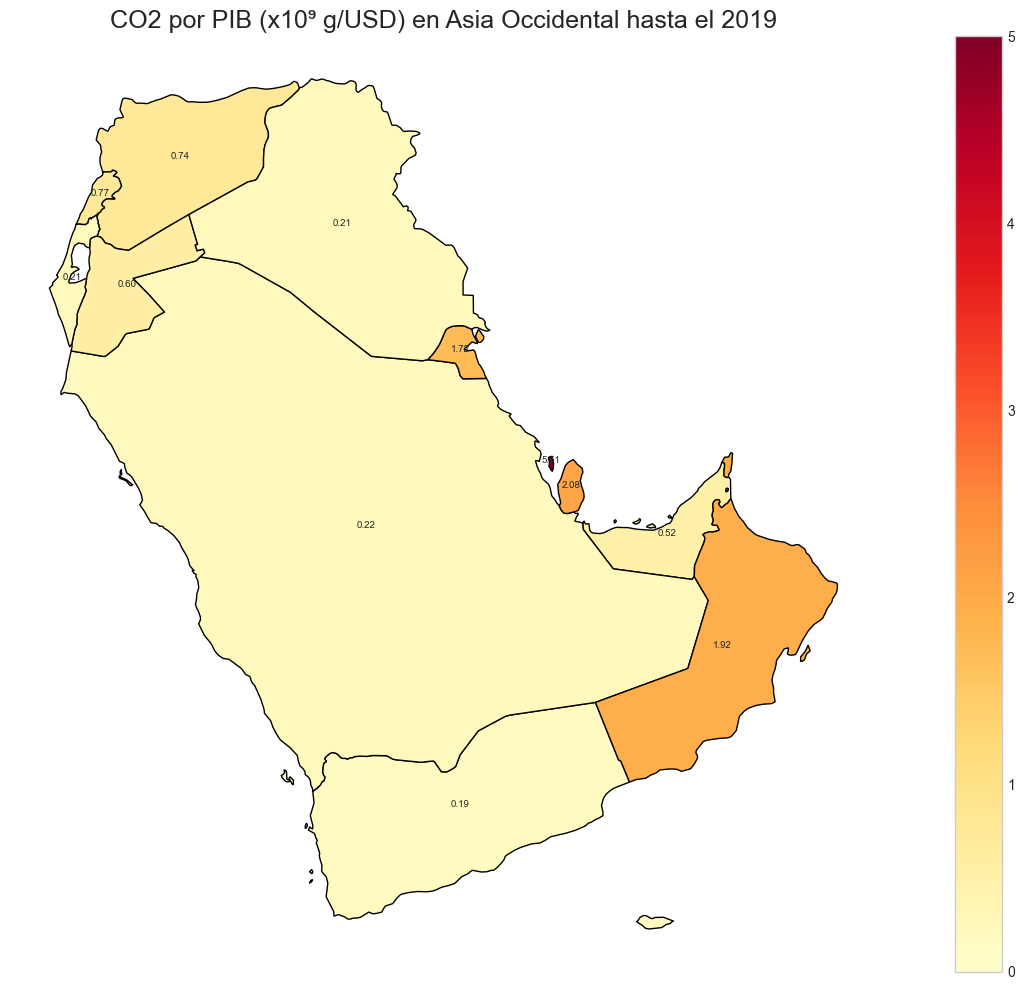

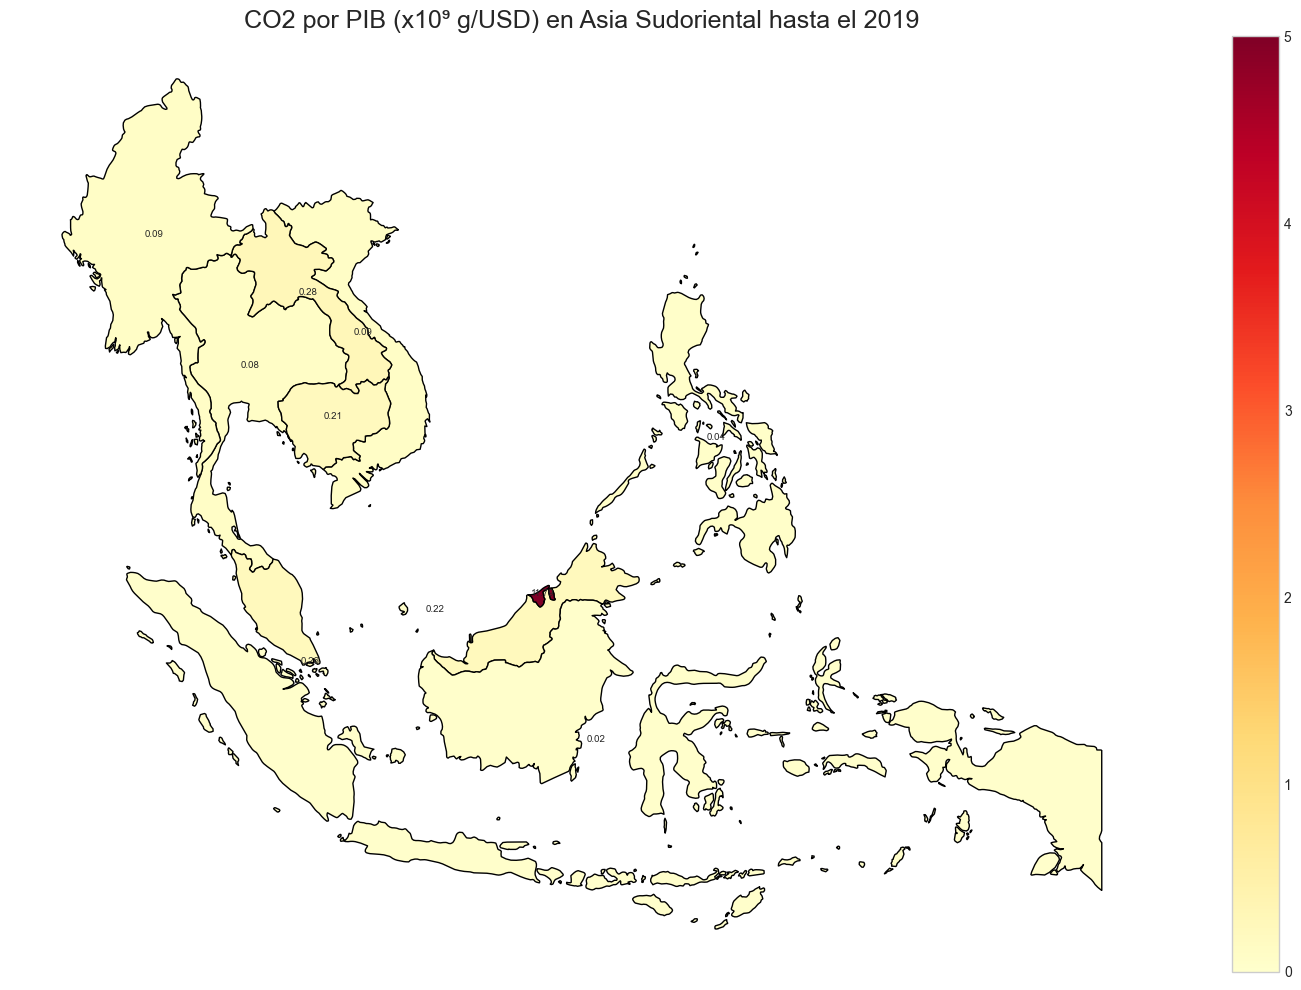

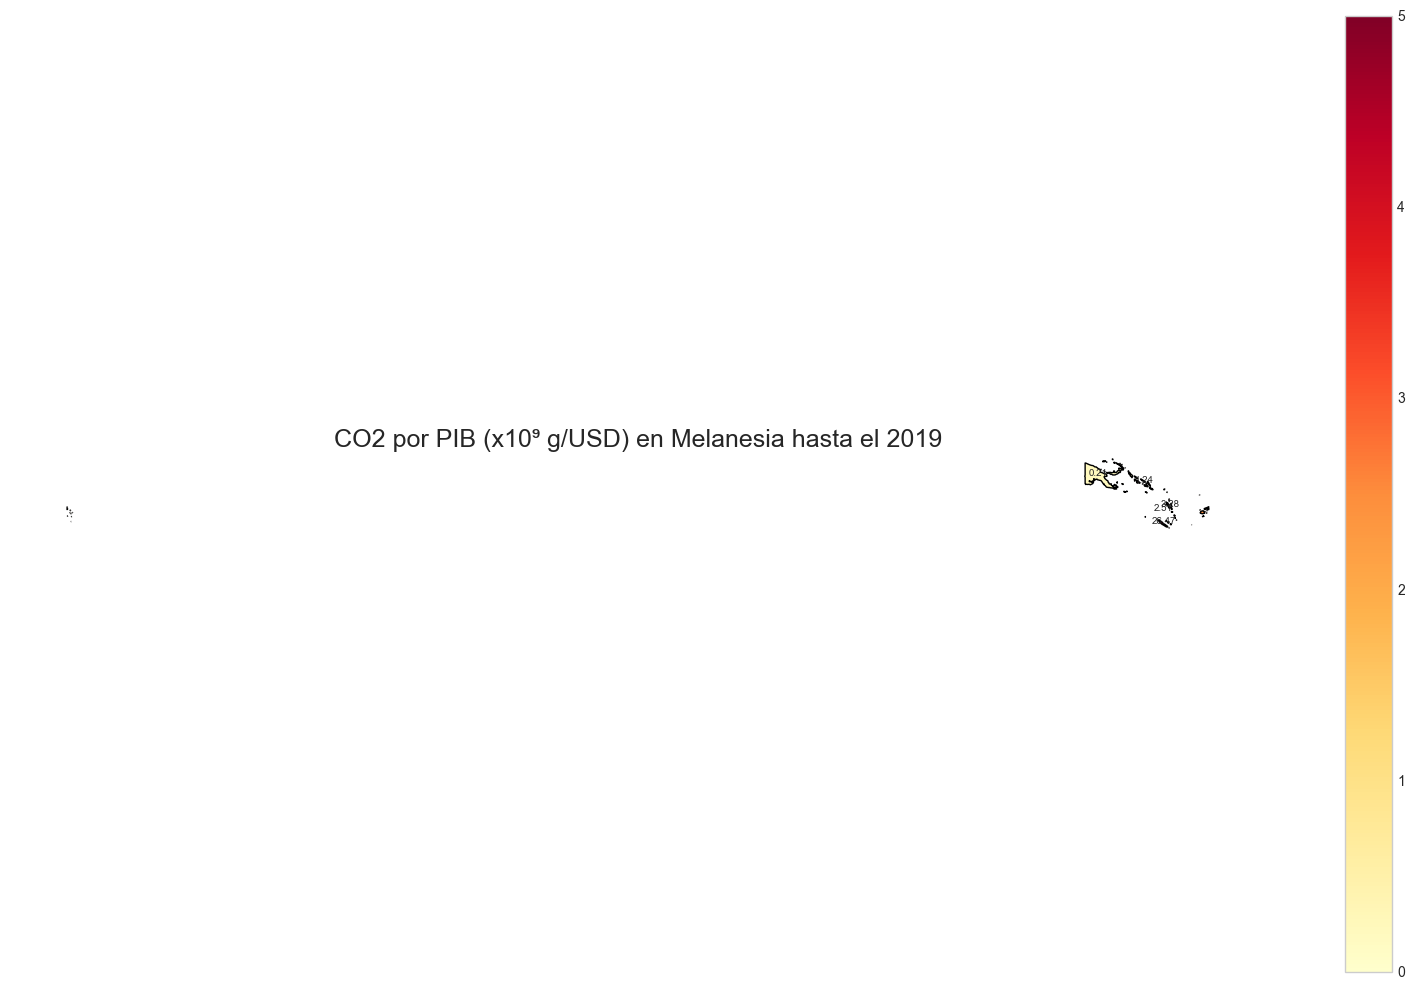

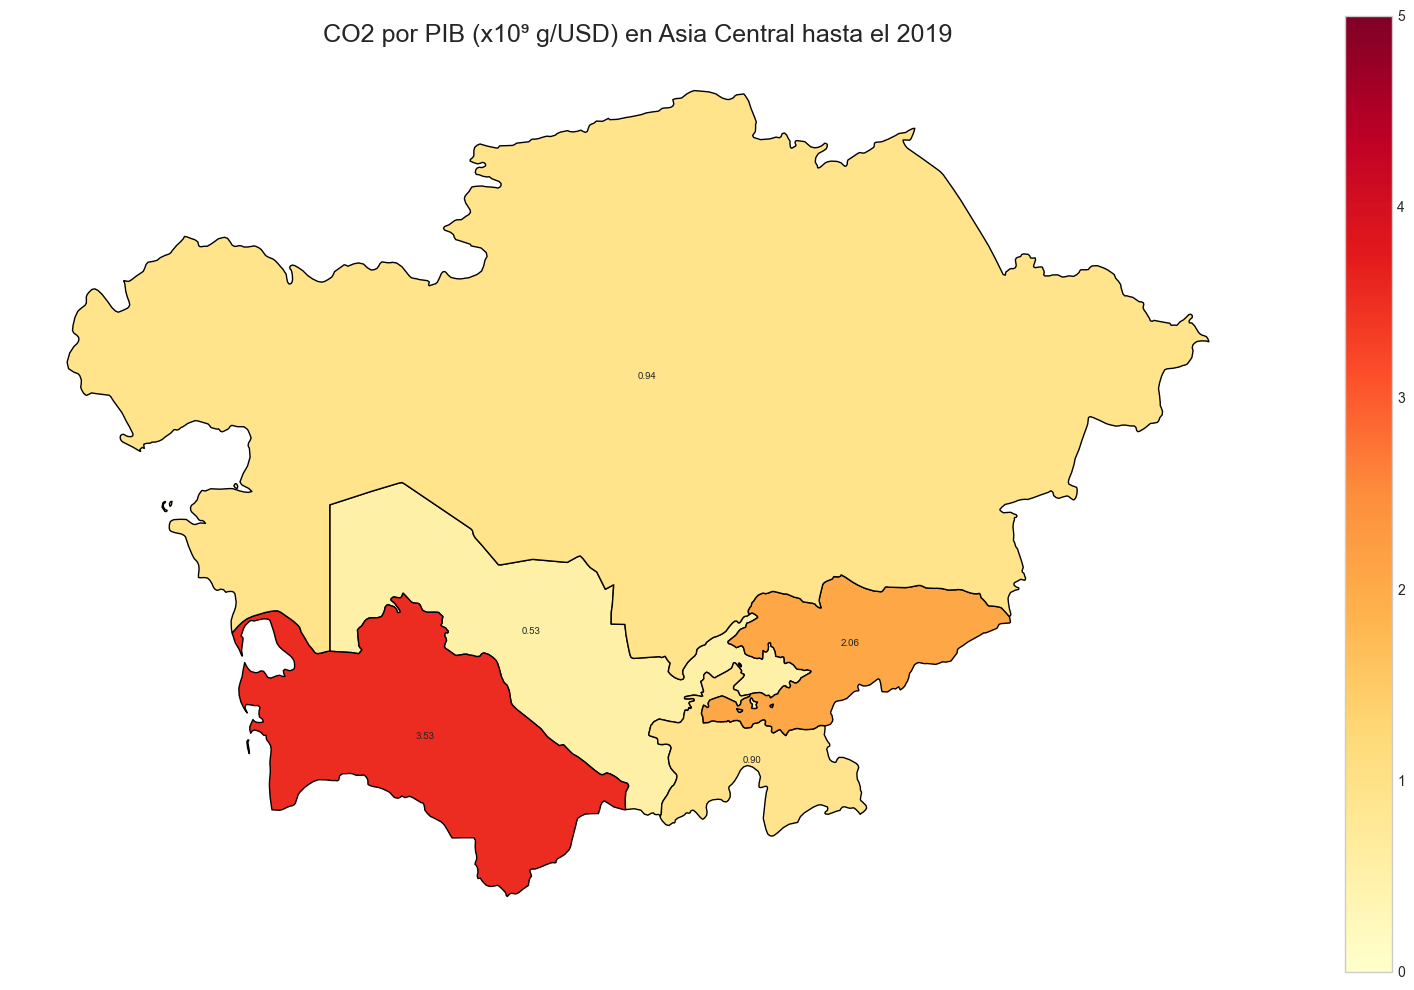

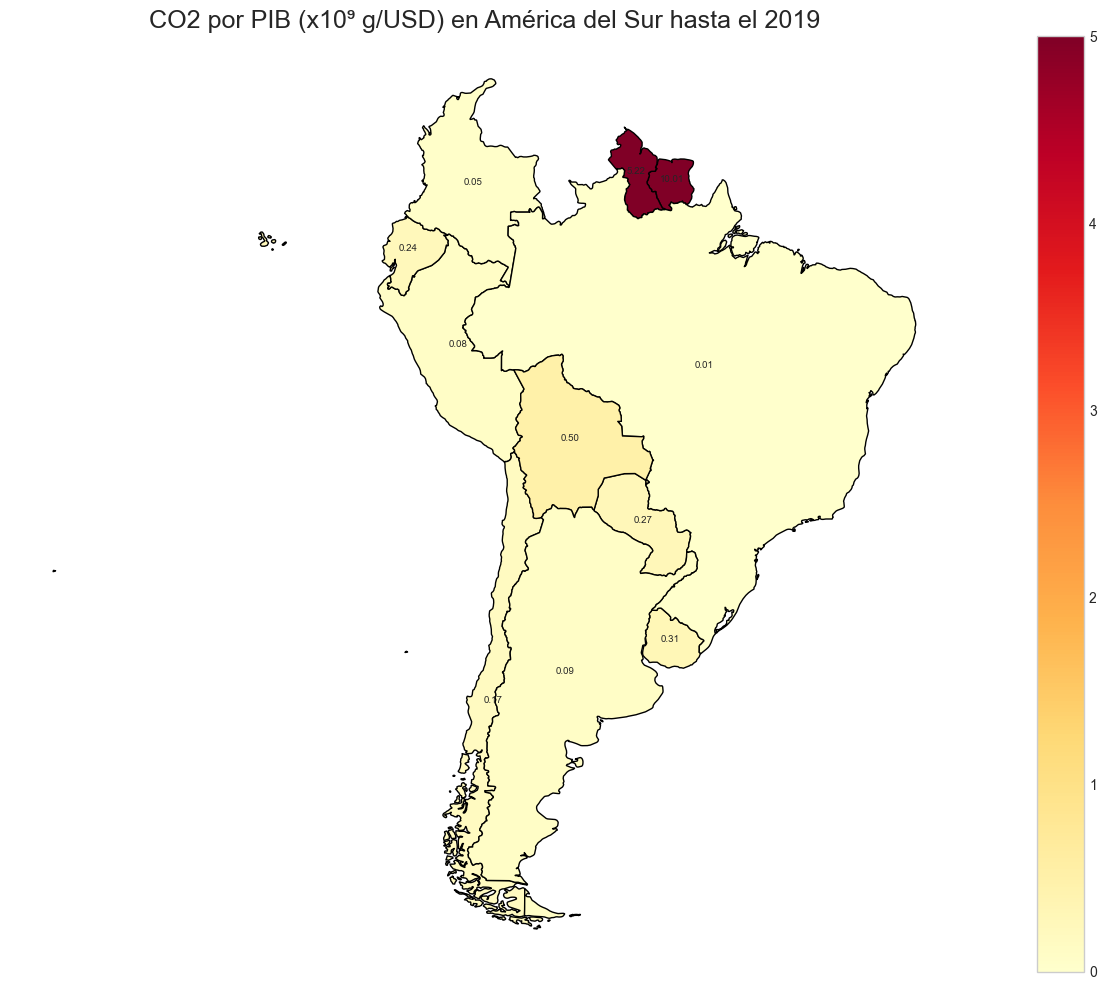

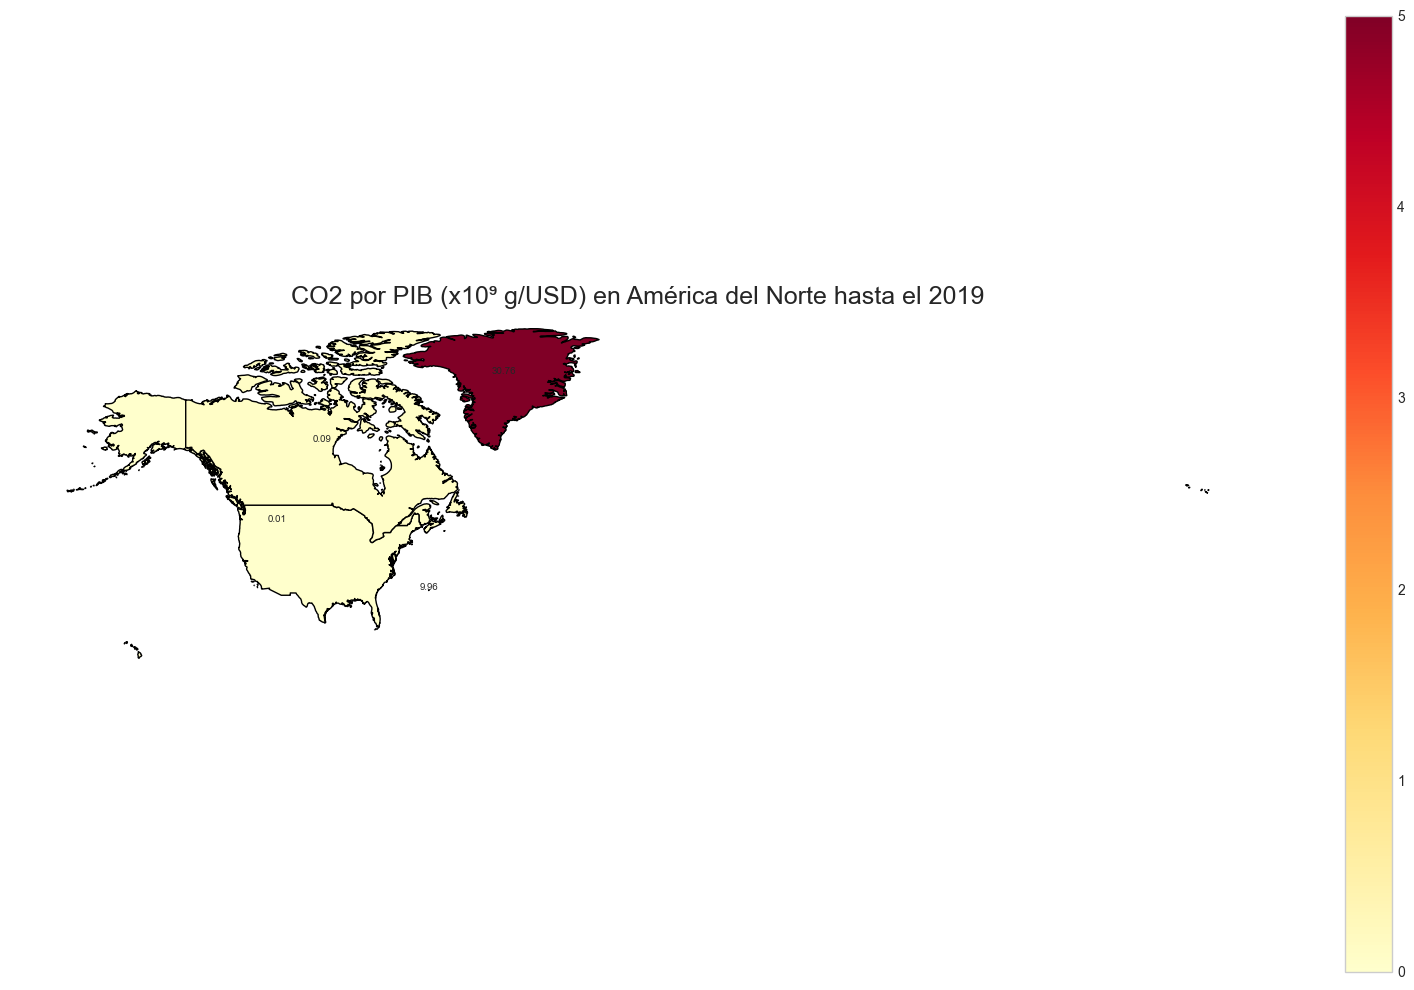

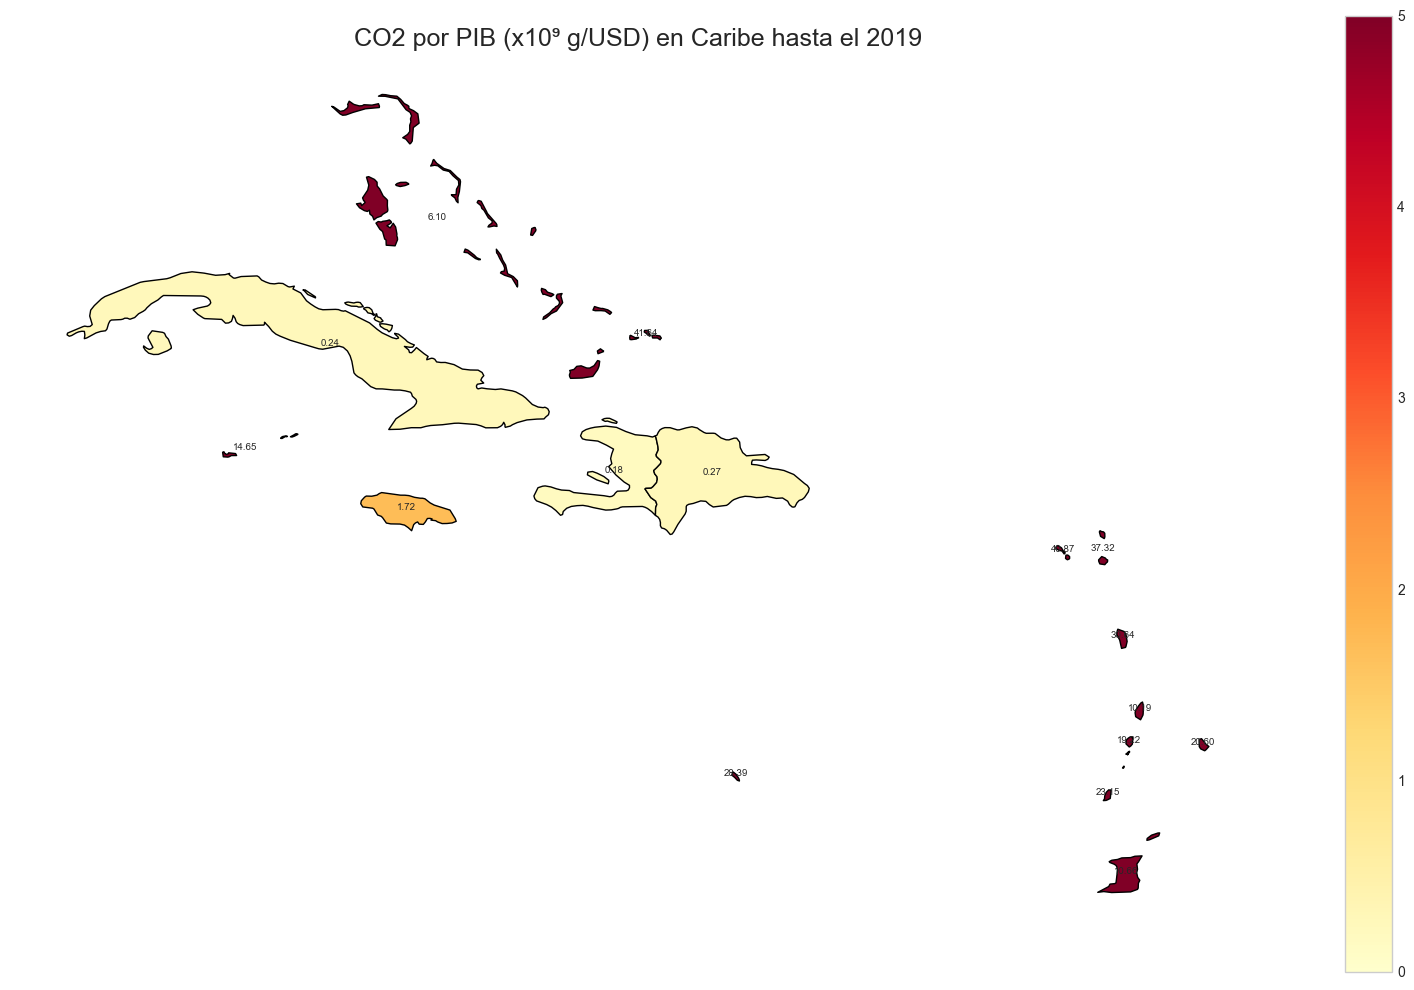

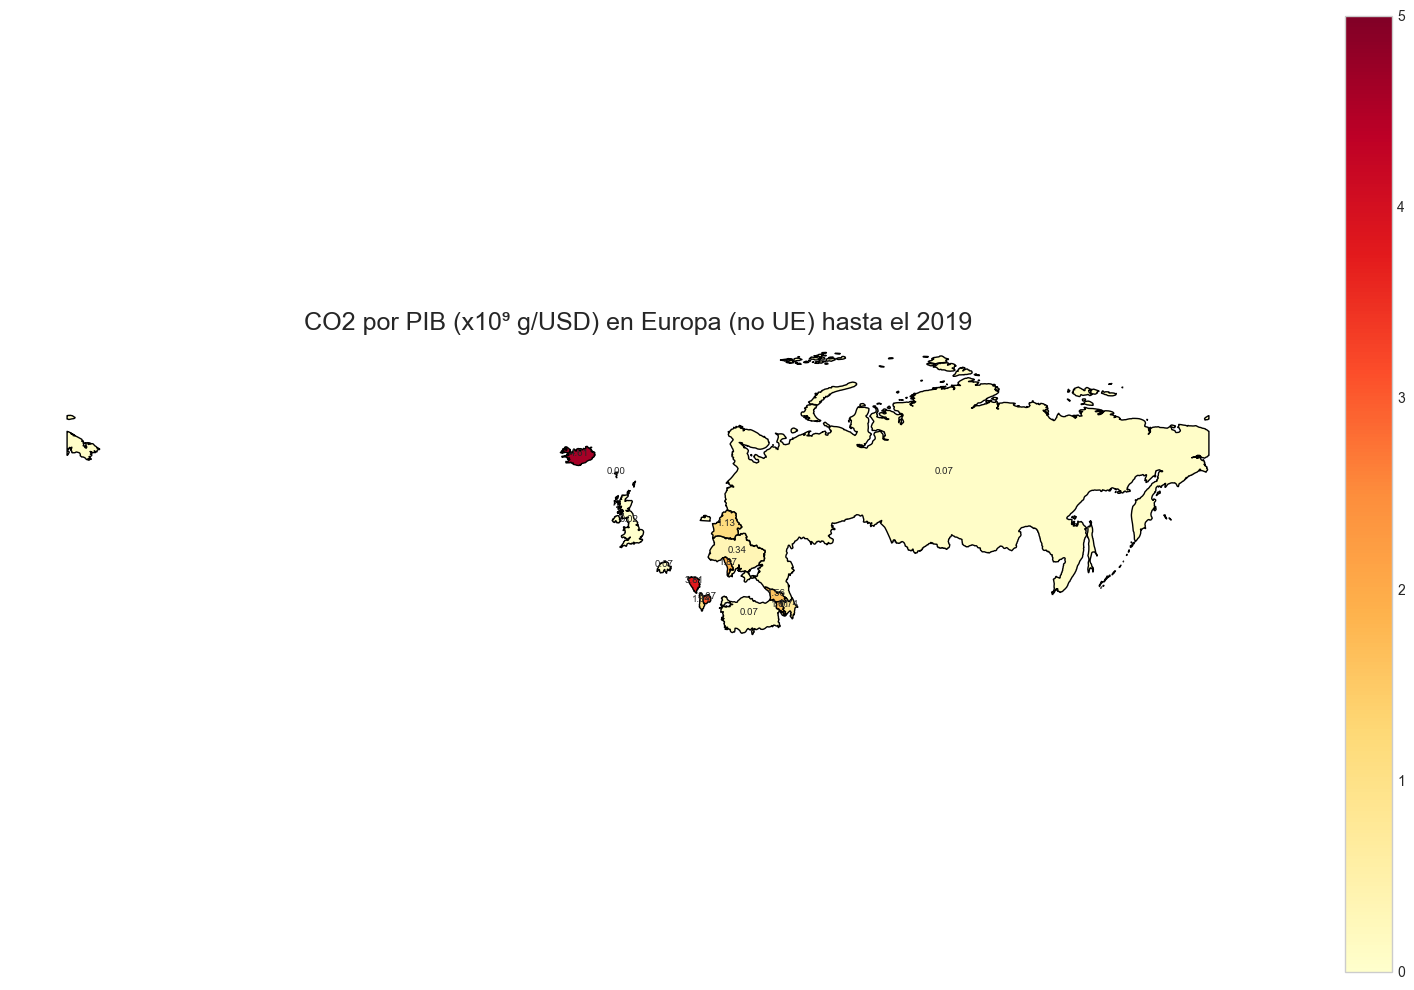

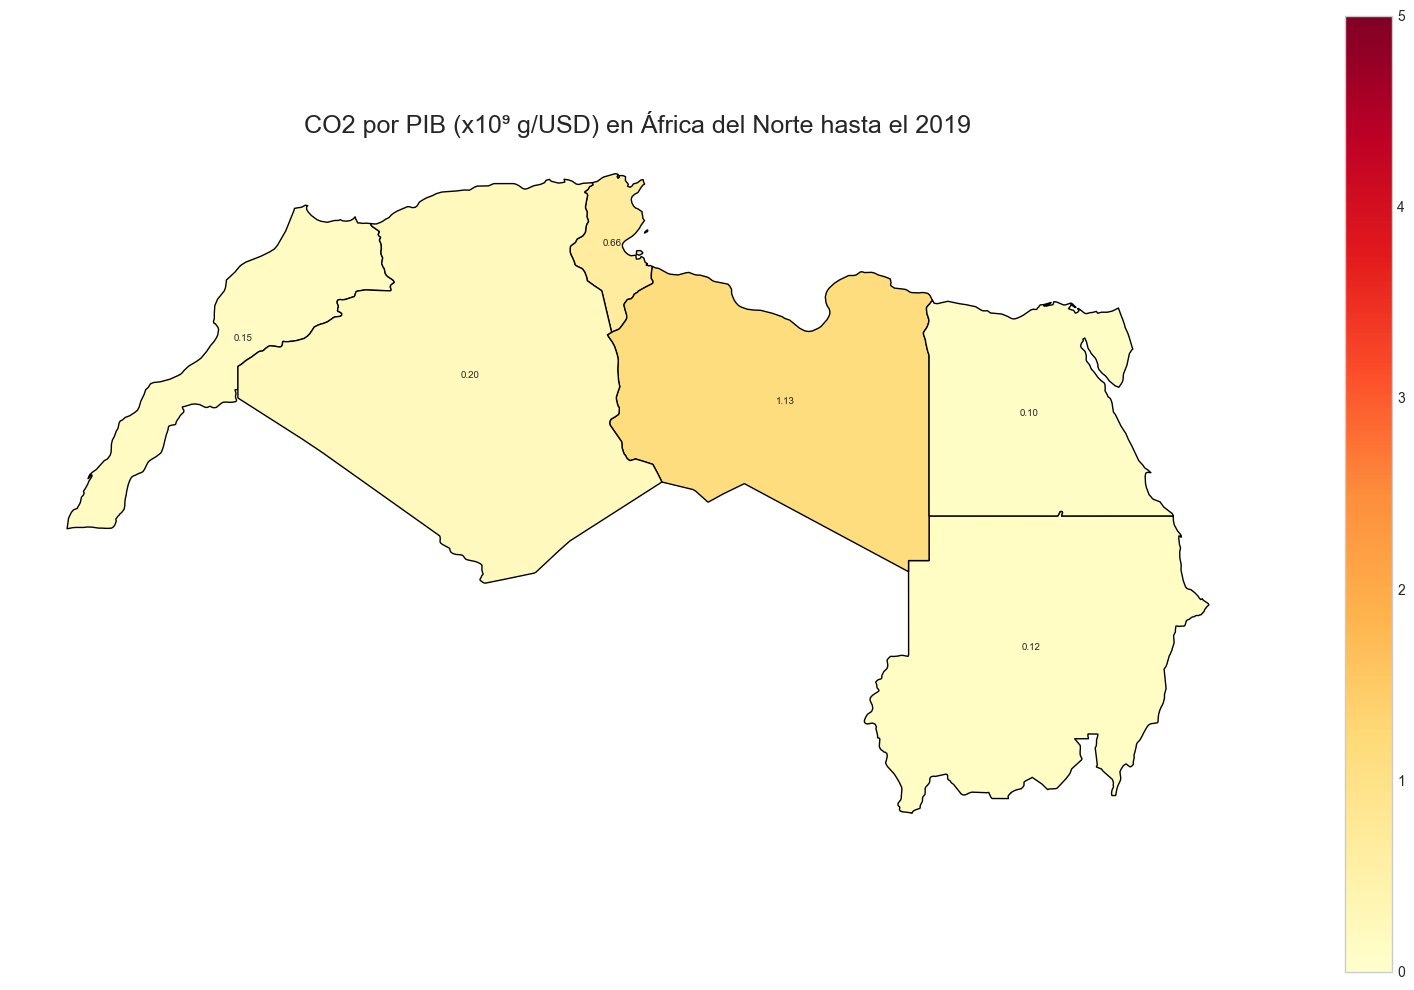

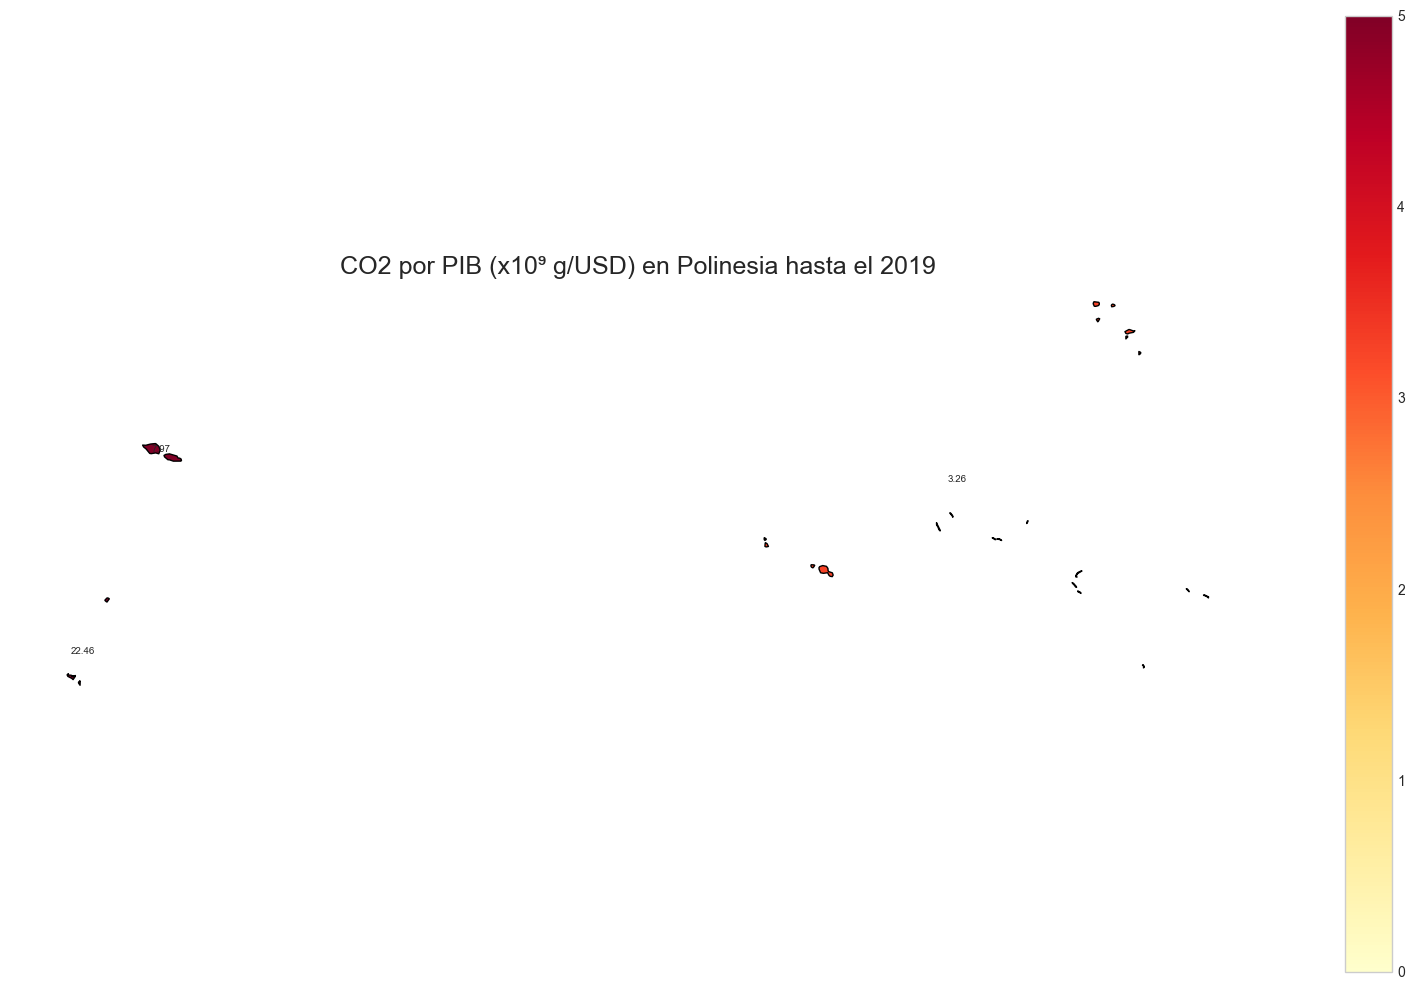

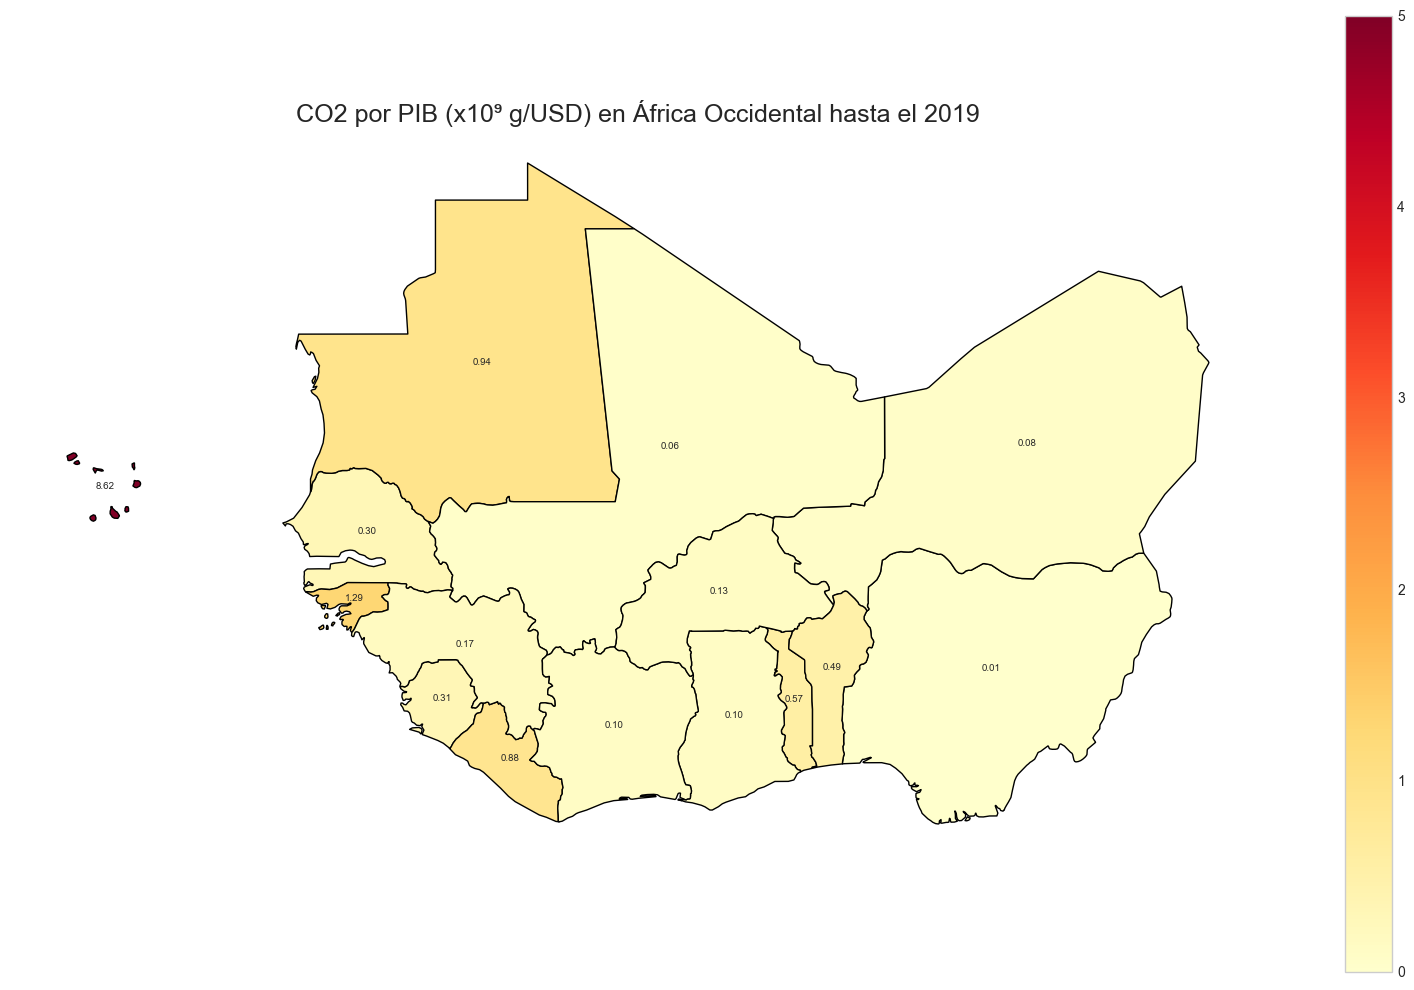

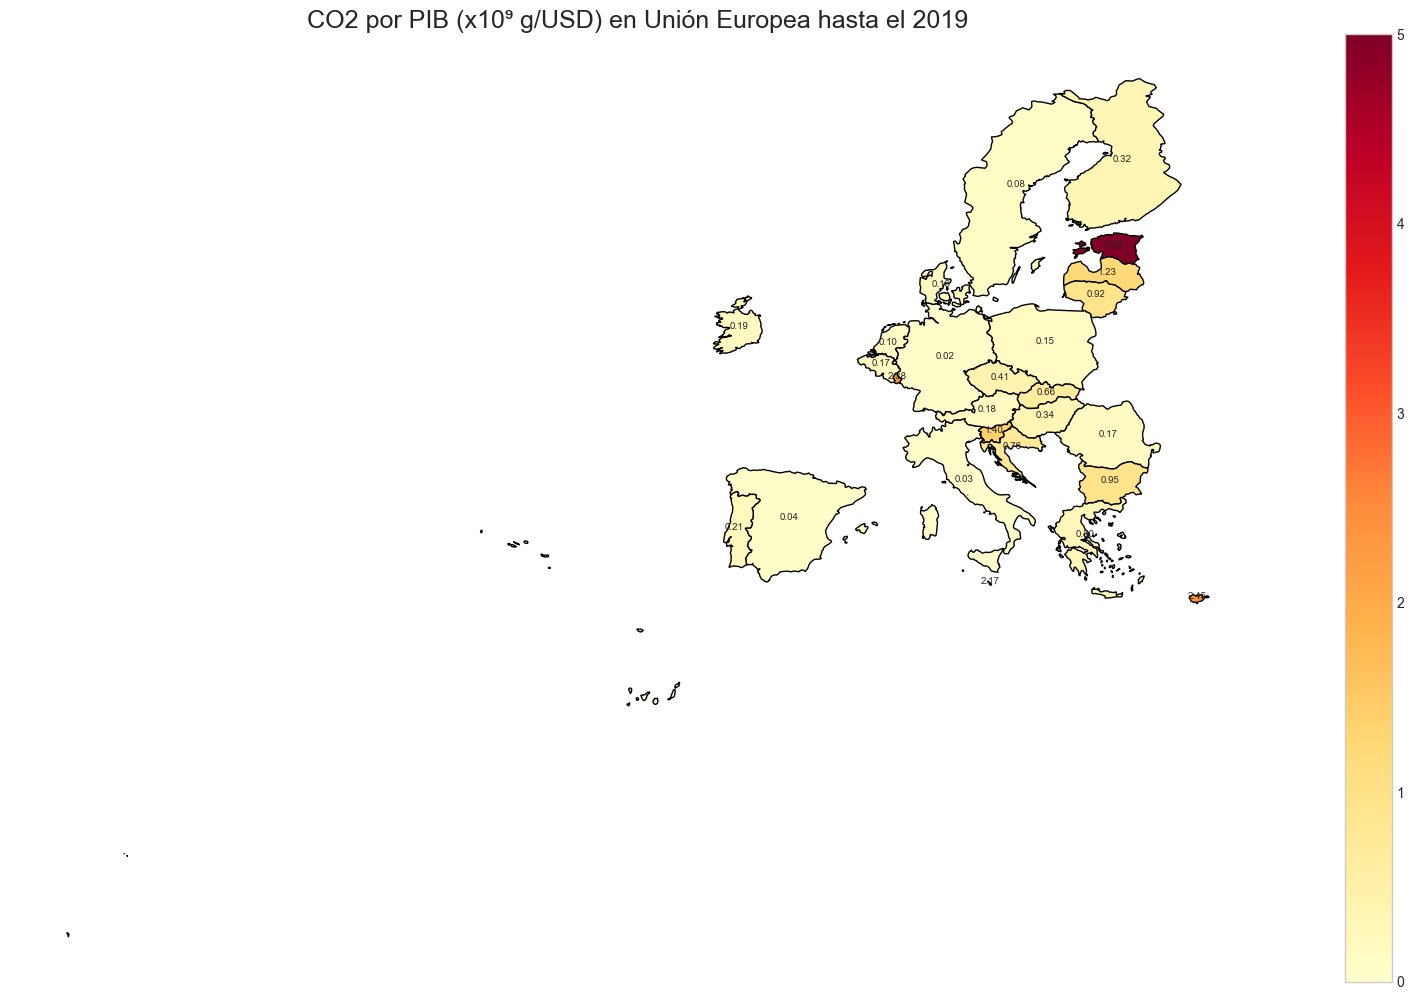

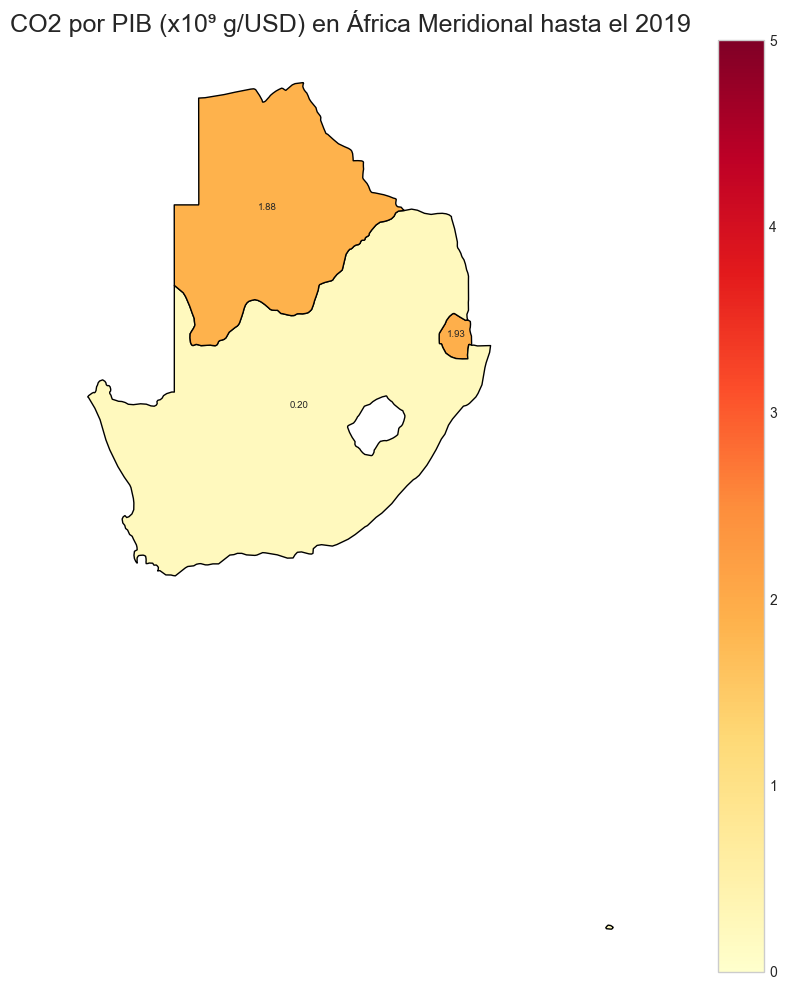

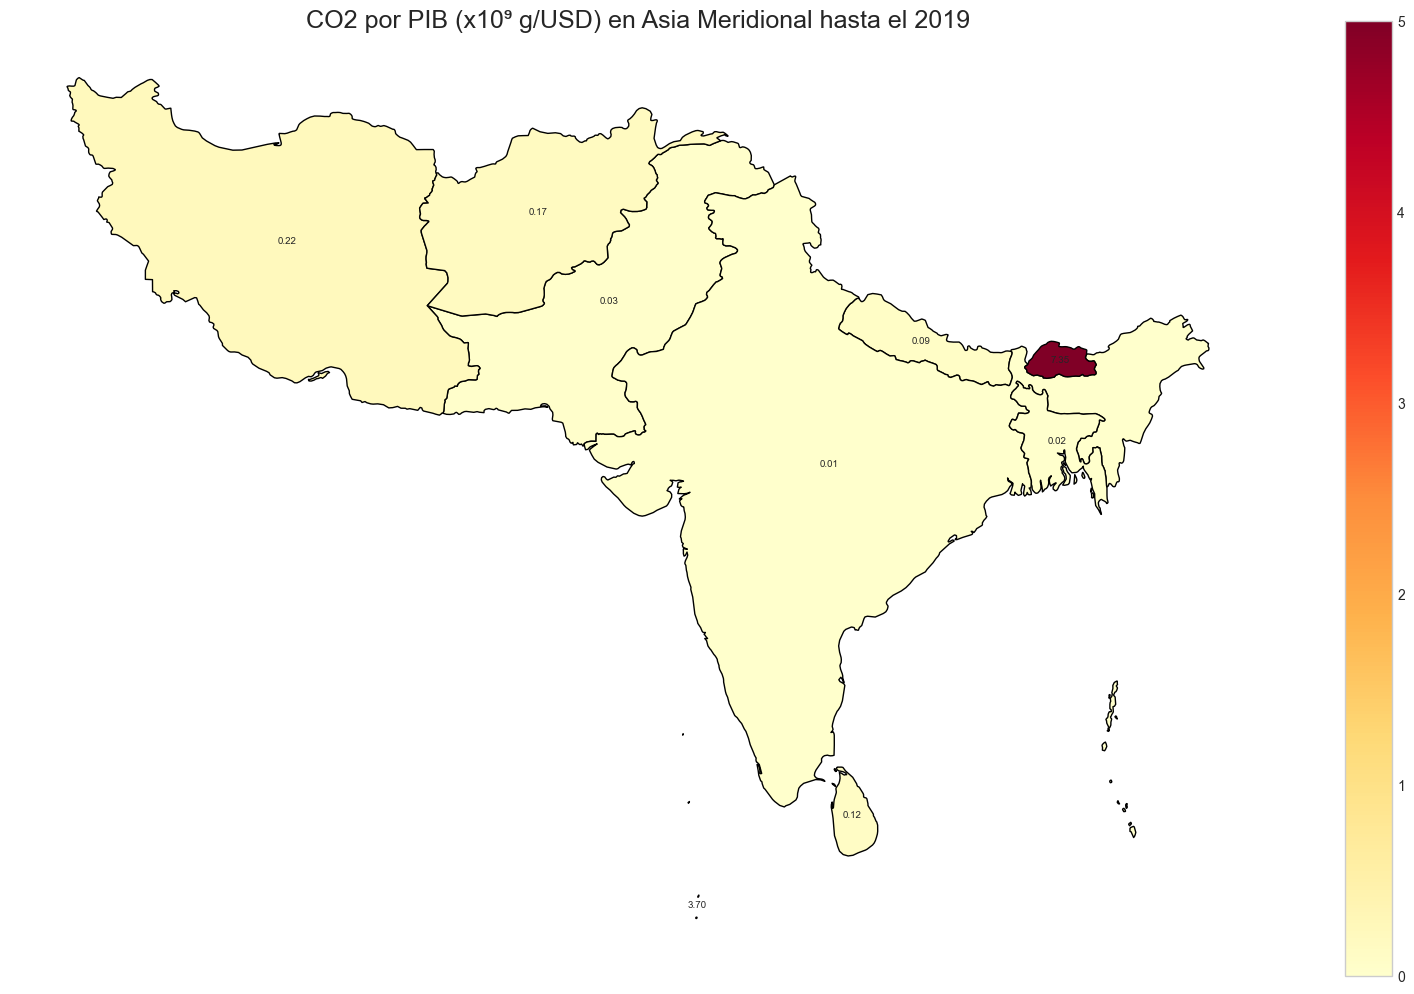

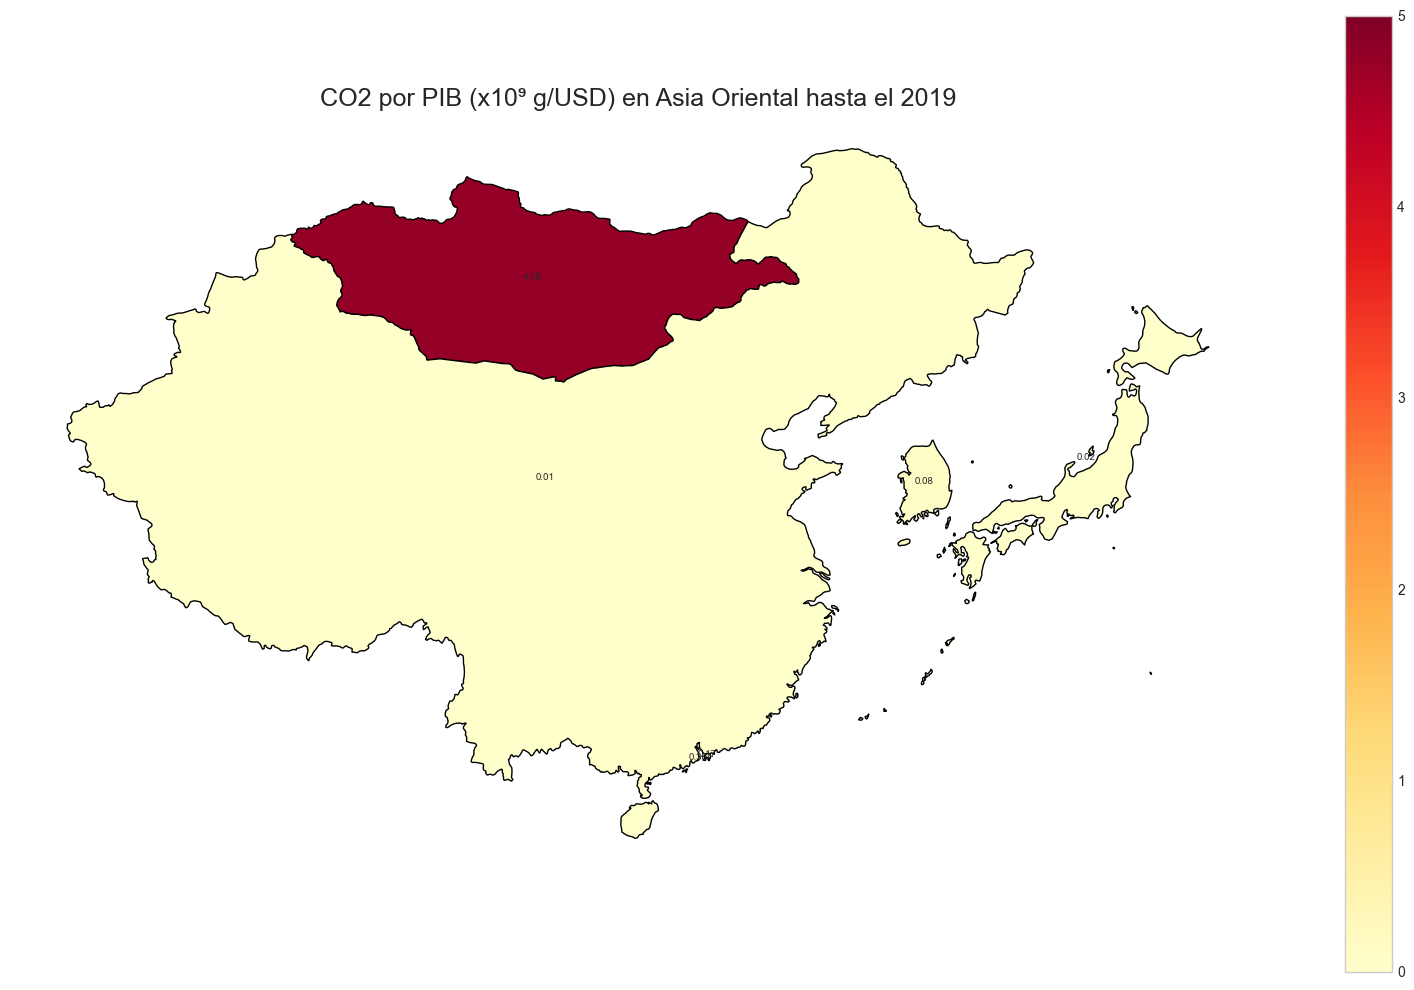

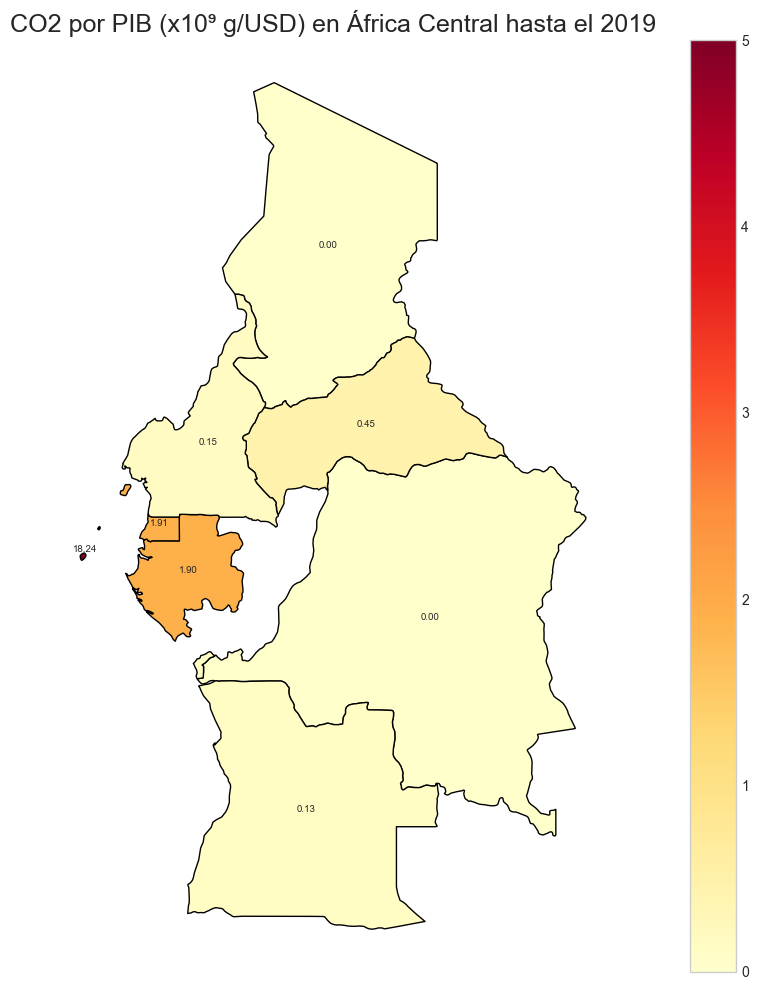

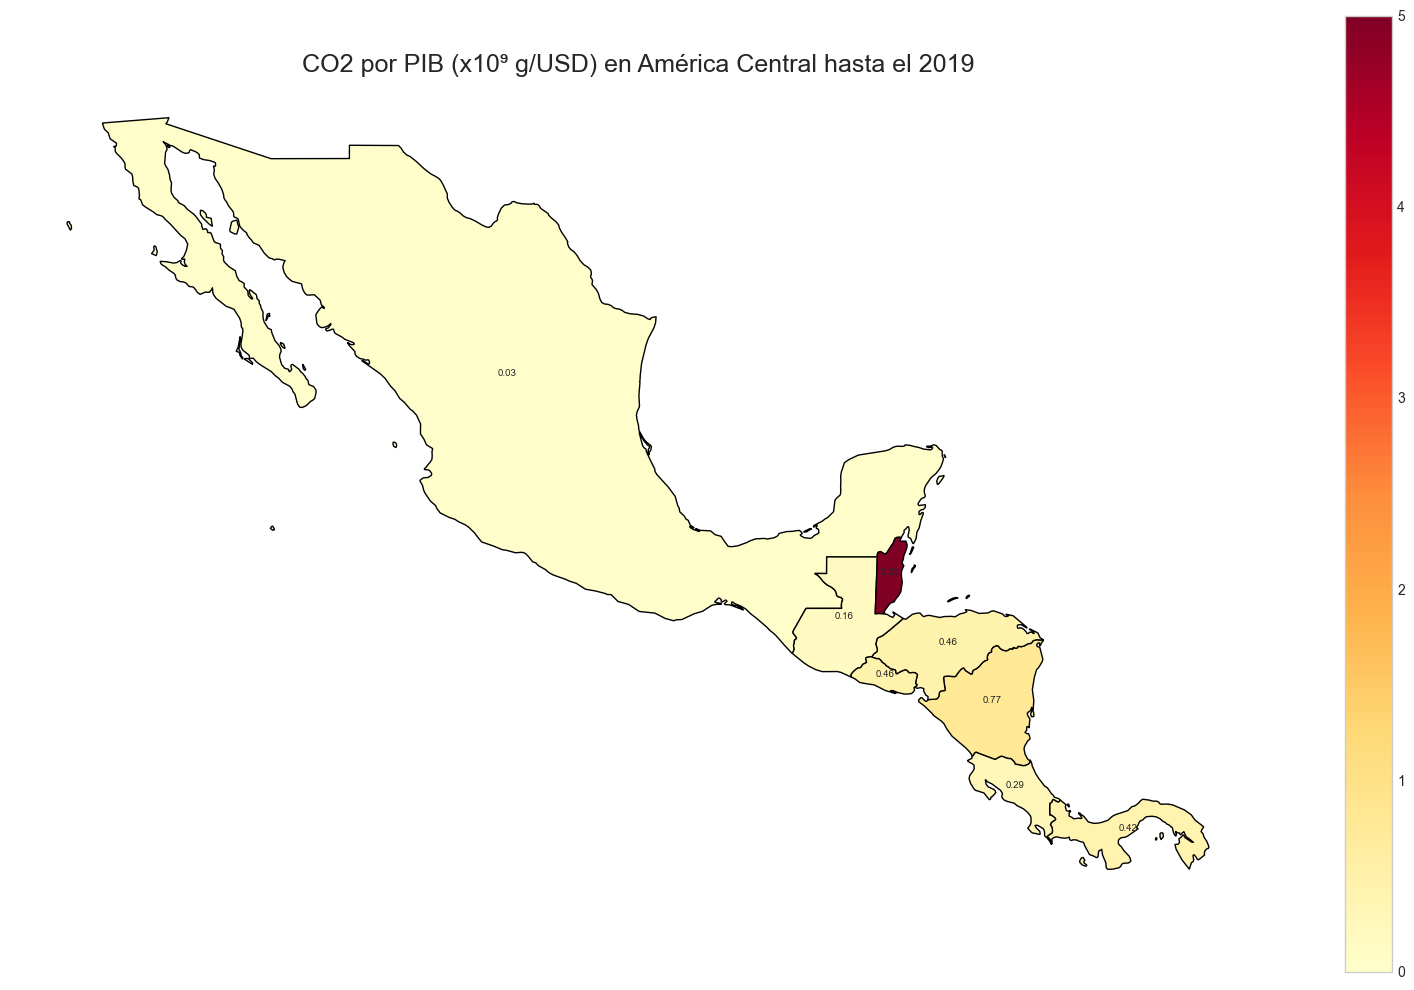

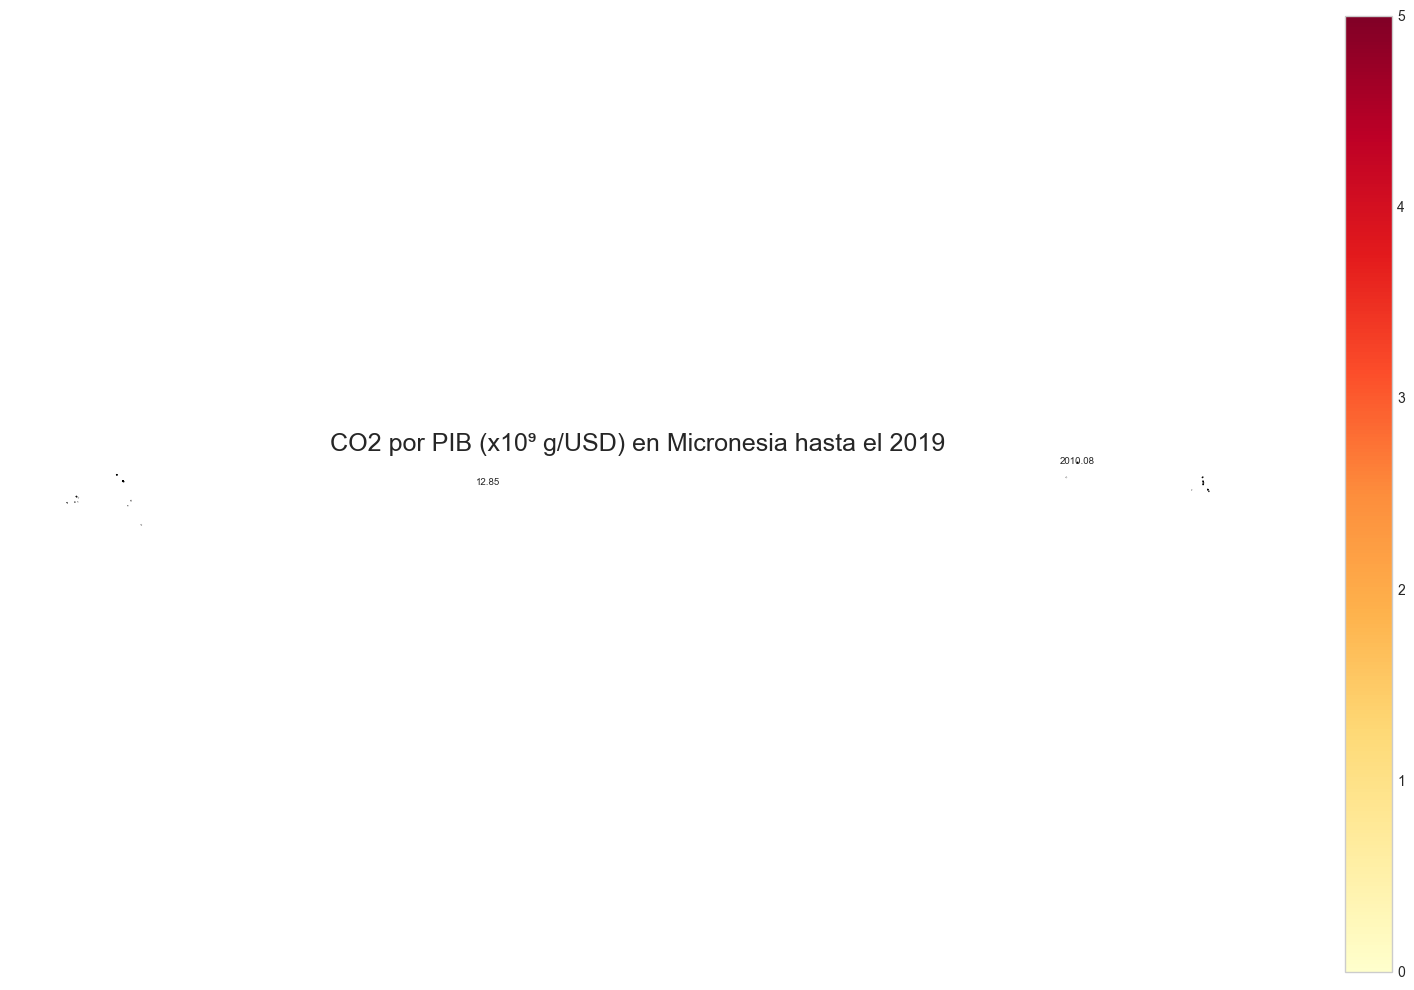

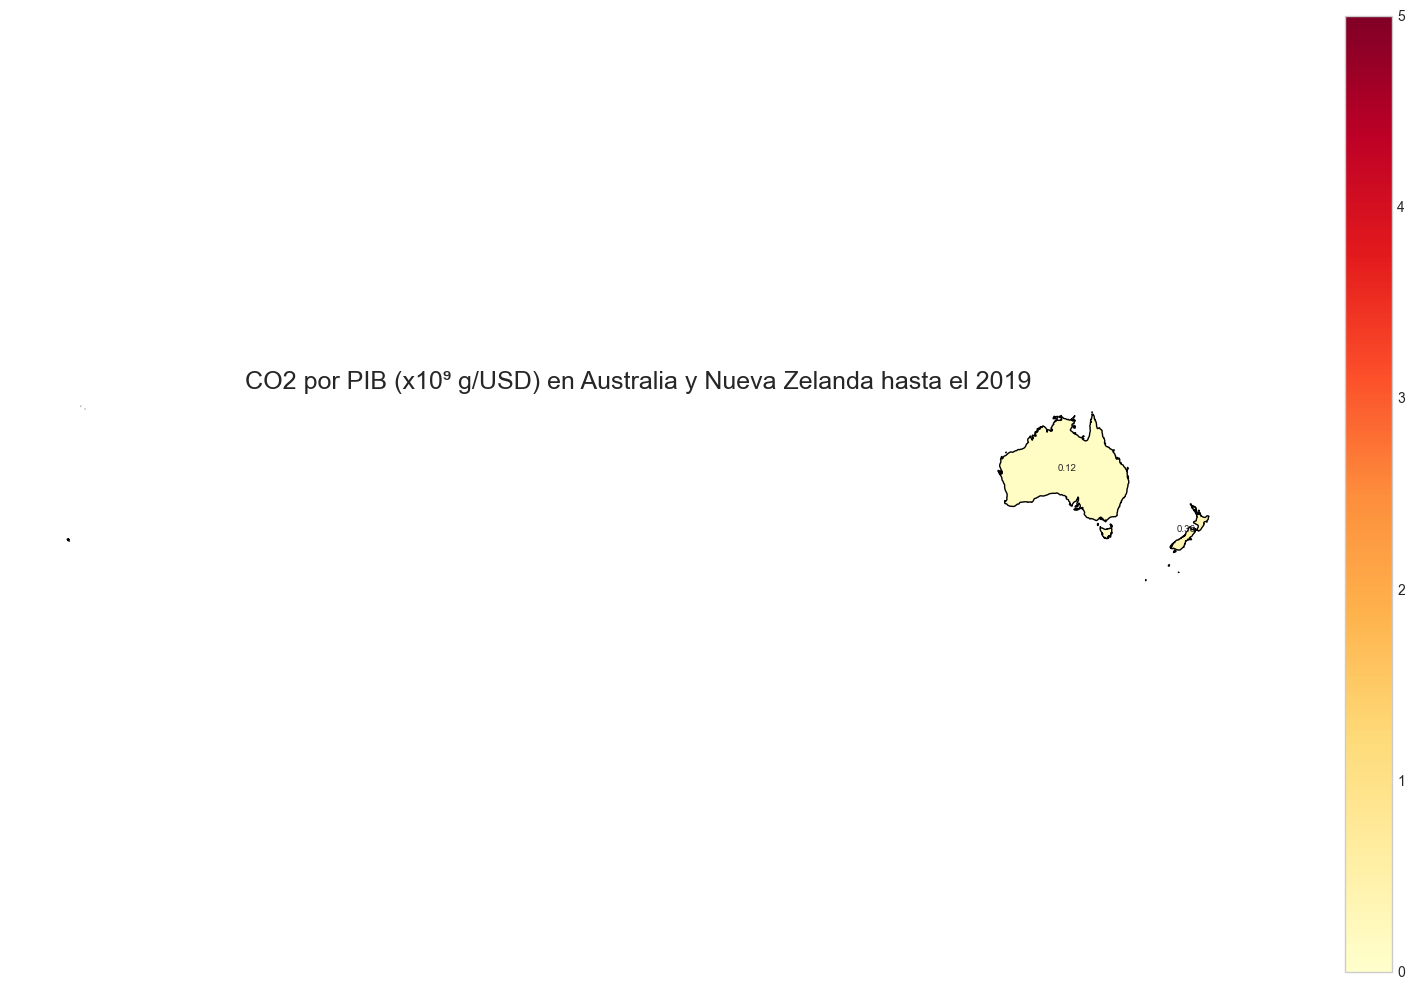

In [30]:
# ========================
# 📄 Consulta SQL: PIB y CO2 de todos los países
# ========================
query = """
SELECT 
    h.anio,
    p.codigo AS pais_codigo,
    p.nombre AS pais_nombre,
    sc.nombre AS subcontinente,
    c.nombre AS continente,
    i.codigo AS indicador_codigo,
    h.valor
FROM hechos h
JOIN paises p ON h.pais_id = p.codigo
JOIN indicadores i ON h.indicador_id = i.id
JOIN subcontinentes sc ON p.subcontinente_id = sc.id
JOIN continentes c ON sc.continente_id = c.id
WHERE (i.id = 2 OR i.codigo = 'NY.GDP.MKTP.CD')
  AND h.anio <= 2019
ORDER BY continente, subcontinente, pais_nombre, i.codigo;
"""

# ========================
# 📥 Ejecutar y preparar datos
# ========================
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry

df = pd.read_sql(query, conn)

# ========================
# 🔁 Pivot: una fila por país, año
# ========================
df_pivot = df.pivot_table(
    index=["anio", "pais_codigo", "pais_nombre", "continente", "subcontinente"],
    columns="indicador_codigo",
    values="valor"
).reset_index()

# ========================
# 💡 Renombrar columnas
# ========================
df_pivot.rename(columns={
    "NY.GDP.MKTP.CD": "PIB",
    "emision_co2": "CO2"
}, inplace=True)

# ========================
# 📆 Filtrar año más reciente con datos válidos
# ========================
df_pivot = df_pivot.dropna(subset=["PIB", "CO2"])
df_pivot = df_pivot[df_pivot["PIB"] > 0]
latest_year = df_pivot["anio"].max()
df_latest = df_pivot[df_pivot["anio"] == latest_year].copy()

# ========================
# ➗ Calcular CO₂ por PIB y escalar
# ========================
df_latest["co2_por_pib"] = df_latest["CO2"] / df_latest["PIB"]
df_latest["co2_por_pib_scaled"] = df_latest["co2_por_pib"] * 1e10  # g/USD

# ========================
# 🌍 Convertir ISO2 → ISO3
# ========================
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_latest["iso_a3"] = df_latest["pais_codigo"].apply(iso2_to_iso3)
df_latest = df_latest[df_latest["iso_a3"].notna()]

# ========================
# 📦 Cargar shapefile y unir
# ========================
shapefile_path = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

map_data = world.merge(df_latest, how="inner", left_on="ISO_A3", right_on="iso_a3")
map_data = map_data[map_data["geometry"].notna()]

# ========================
# 🎯 Escala común para todos los mapas
# ========================
vmin = 0.0
vmax = 5.0

# ========================
# 🗺️ Dibujar mapas por subcontinente
# ========================
subcontinentes = map_data["subcontinente"].unique()

for subcont in subcontinentes:
    subset = map_data[map_data["subcontinente"] == subcont]

    if subset.empty:
        continue

    ax = subset.plot(
        column="co2_por_pib_scaled",
        cmap="YlOrRd",
        legend=True,
        figsize=(16, 10),
        edgecolor="black",
        missing_kwds={"color": "lightgrey"},
        vmin=vmin,
        vmax=vmax
    )

    plt.title(f"CO2 por PIB (x10⁹ g/USD) en {subcont} hasta el 2019", fontsize=18)

    for idx, row in subset.iterrows():
        if row["geometry"].centroid.is_empty:
            continue
        x, y = row["geometry"].centroid.coords[0]
        plt.text(x, y, f"{row['co2_por_pib_scaled']:.2f}", fontsize=7, ha='center')

    plt.axis("off")
    plt.tight_layout()
    plt.show()


## 1. Resumen de Datos Disponibles

Primero, exploramos la cantidad de datos disponibles por país y año para tener una visión general de la cobertura de nuestro dataset.

In [2]:
# Consulta para obtener la cantidad de datos por país y año para emisiones de CO₂
query_resumen = """
SELECT 
    COUNT(DISTINCT p.codigo) AS num_paises,
    MIN(h.anio) AS anio_min,
    MAX(h.anio) AS anio_max,
    COUNT(DISTINCT h.anio) AS num_anios,
    COUNT(*) AS num_registros
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'emision_co2';
"""

df_resumen = pd.read_sql(query_resumen, conn)

# Mostrar resumen
print("Resumen de datos de emisiones de CO₂:")
print(f"Número de países: {df_resumen['num_paises'].values[0]}")
print(f"Rango de años: {df_resumen['anio_min'].values[0]} - {df_resumen['anio_max'].values[0]} ({df_resumen['num_anios'].values[0]} años)")
print(f"Total de registros: {df_resumen['num_registros'].values[0]}")

# Consulta para obtener la cantidad de datos por país y año para PIB
query_resumen_pib = """
SELECT 
    COUNT(DISTINCT p.codigo) AS num_paises,
    MIN(h.anio) AS anio_min,
    MAX(h.anio) AS anio_max,
    COUNT(DISTINCT h.anio) AS num_anios,
    COUNT(*) AS num_registros
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'NY.GDP.MKTP.CD';
"""

df_resumen_pib = pd.read_sql(query_resumen_pib, conn)

# Mostrar resumen
print("\nResumen de datos de PIB:")
print(f"Número de países: {df_resumen_pib['num_paises'].values[0]}")
print(f"Rango de años: {df_resumen_pib['anio_min'].values[0]} - {df_resumen_pib['anio_max'].values[0]} ({df_resumen_pib['num_anios'].values[0]} años)")
print(f"Total de registros: {df_resumen_pib['num_registros'].values[0]}")

Resumen de datos de emisiones de CO₂:
Número de países: 198
Rango de años: 1990 - 2021 (28 años)
Total de registros: 5422

Resumen de datos de PIB:
Número de países: 209
Rango de años: 1960 - 2023 (64 años)
Total de registros: 11187


C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\1188947418.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resumen = pd.read_sql(query_resumen, conn)
C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\1188947418.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resumen_pib = pd.read_sql(query_resumen_pib, conn)


## 2. Tendencia Global de Emisiones de CO₂

Analizamos la evolución de las emisiones globales de CO₂ a lo largo del tiempo.

C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\2875348890.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_global = pd.read_sql(query_global, conn)
C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\2875348890.py:47: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


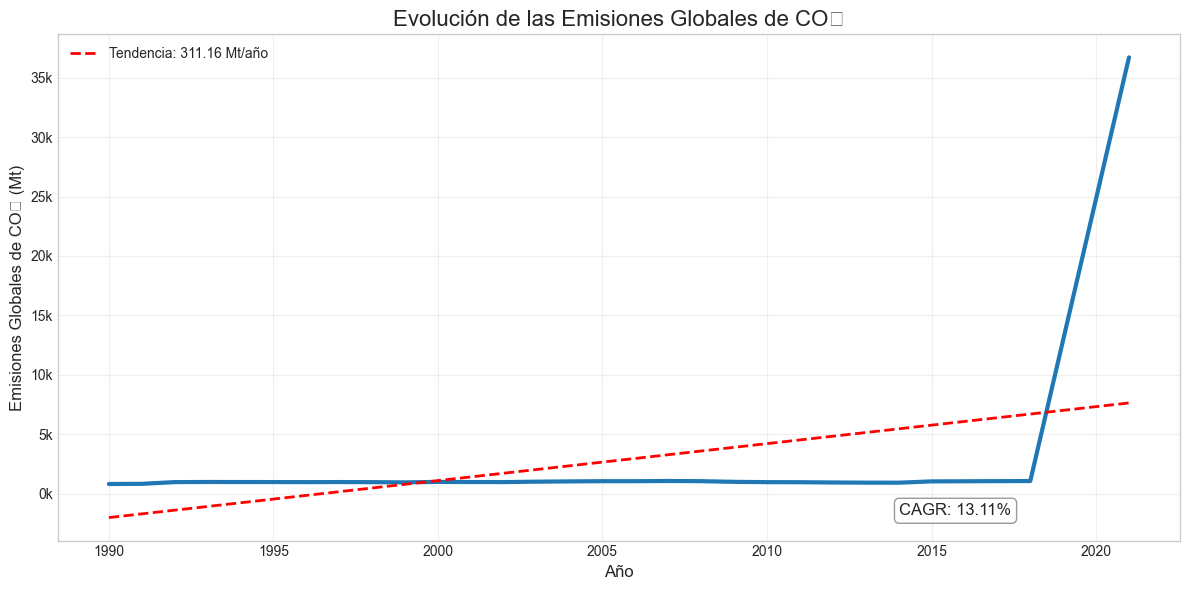

In [ ]:
# ========================
# 📄 Consulta SQL: PIB y CO2 de todos los países
# ========================
query = """
SELECT 
    h.anio,
    p.codigo AS pais_codigo,
    p.nombre AS pais_nombre,
    sc.nombre AS subcontinente,
    c.nombre AS continente,
    i.codigo AS indicador_codigo,
    h.valor
FROM hechos h
JOIN paises p ON h.pais_id = p.codigo
JOIN indicadores i ON h.indicador_id = i.id
JOIN subcontinentes sc ON p.subcontinente_id = sc.id
JOIN continentes c ON sc.continente_id = c.id
WHERE (i.id = 2 OR i.codigo = 'NY.GDP.MKTP.CD')
  AND h.anio <= 2019
ORDER BY continente, subcontinente, pais_nombre, i.codigo;
"""

# ========================
# 📥 Ejecutar y preparar datos
# ========================
df = pd.read_sql(query, conn)

# ========================
# 🔁 Pivot: una fila por país, año
# ========================
df_pivot = df.pivot_table(
    index=["anio", "pais_codigo", "pais_nombre", "continente", "subcontinente"],
    columns="indicador_codigo",
    values="valor"
).reset_index()

# ========================
# 💡 Normalizar nombres de columnas
# ========================
df_pivot.rename(columns={
    "NY.GDP.MKTP.CD": "PIB",
    "emision_co2": "CO2"
}, inplace=True)

# ========================
# 📆 Filtrar último año con datos válidos
# ========================
df_pivot = df_pivot.dropna(subset=["PIB", "CO2"])
df_pivot = df_pivot[df_pivot["PIB"] > 0]
latest_year = df_pivot["anio"].max()
df_latest = df_pivot[df_pivot["anio"] == latest_year].copy()

# ========================
# ➗ Calcular CO2 por PIB
# ========================
df_latest["co2_por_pib"] = df_latest["CO2"] / df_latest["PIB"]

# ========================
# 🌍 Convertir ISO2 → ISO3
# ========================
import pycountry
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_latest["iso_a3"] = df_latest["pais_codigo"].apply(iso2_to_iso3)
df_latest = df_latest[df_latest["iso_a3"].notna()]

# ========================
# 🗺️ Cargar shapefile y merge
# ========================
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = "./../../visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
map_data = world.merge(df_latest, how="inner", left_on="ISO_A3", right_on="iso_a3")
map_data = map_data[map_data["geometry"].notna()]

# ========================
# 📊 Graficar mapas por continente
# ========================
continentes = map_data["continente"].unique()

for cont in continentes:
    subset = map_data[map_data["continente"] == cont]

    if subset.empty:
        continue

    ax = subset.plot(
        column="co2_por_pib",
        cmap="YlOrRd",
        legend=True,
        figsize=(12, 8),
        edgecolor="black",
        missing_kwds={"color": "lightgrey"}
    )
    plt.title(f"CO₂ por PIB en {cont} ({latest_year})", fontsize=16)

    # Anotar cada país
    for idx, row in subset.iterrows():
        if row["geometry"].centroid.is_empty:
            continue
        x, y = row["geometry"].centroid.coords[0]
        plt.text(x, y, f"{row['co2_por_pib']:.2e}", fontsize=7, ha='center')

    plt.axis("off")
    plt.show()


## 3. Emisiones de CO₂ por Continente

Analizamos la contribución de cada continente a las emisiones globales y su evolución.

C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\2365128906.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_continentes = pd.read_sql(query_continentes, conn)
C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\2365128906.py:36: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


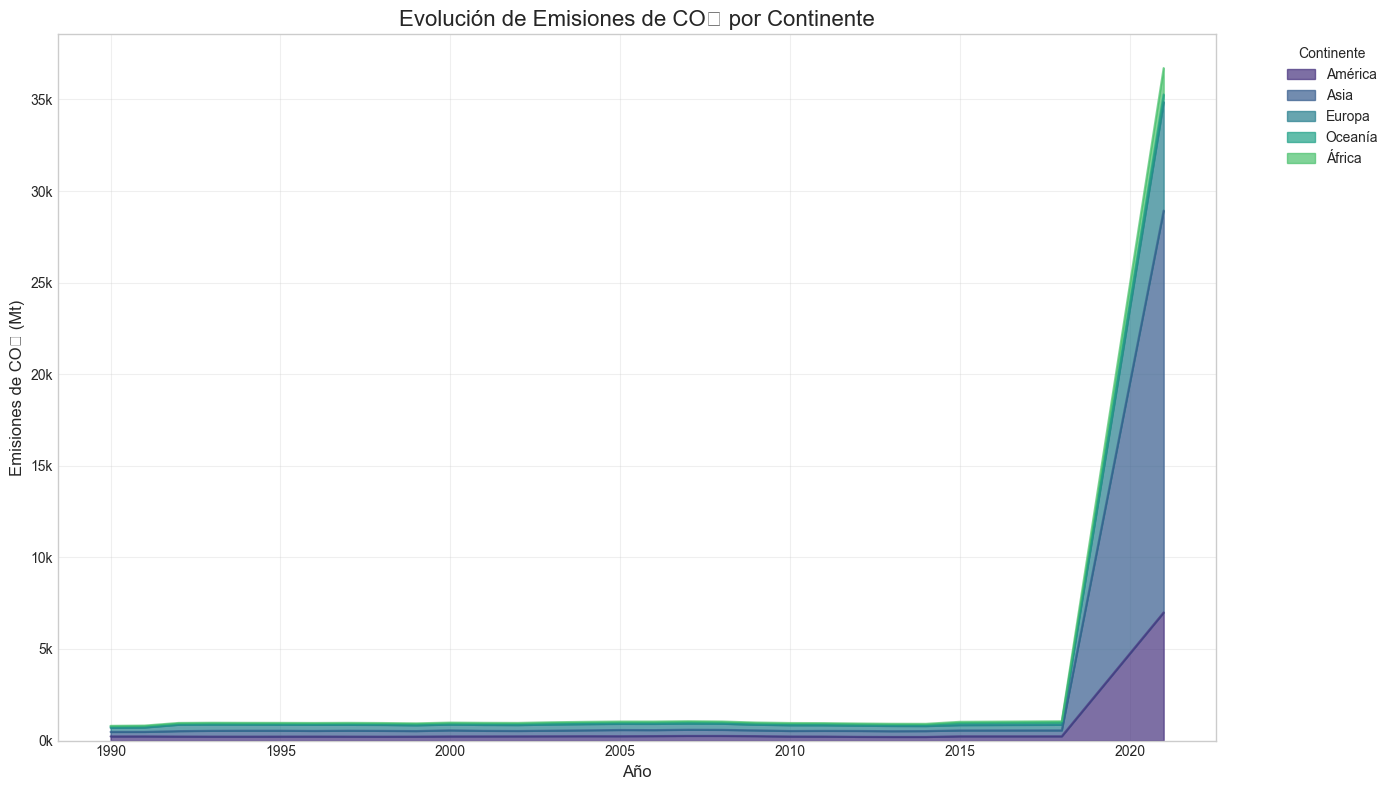

C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\2365128906.py:51: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


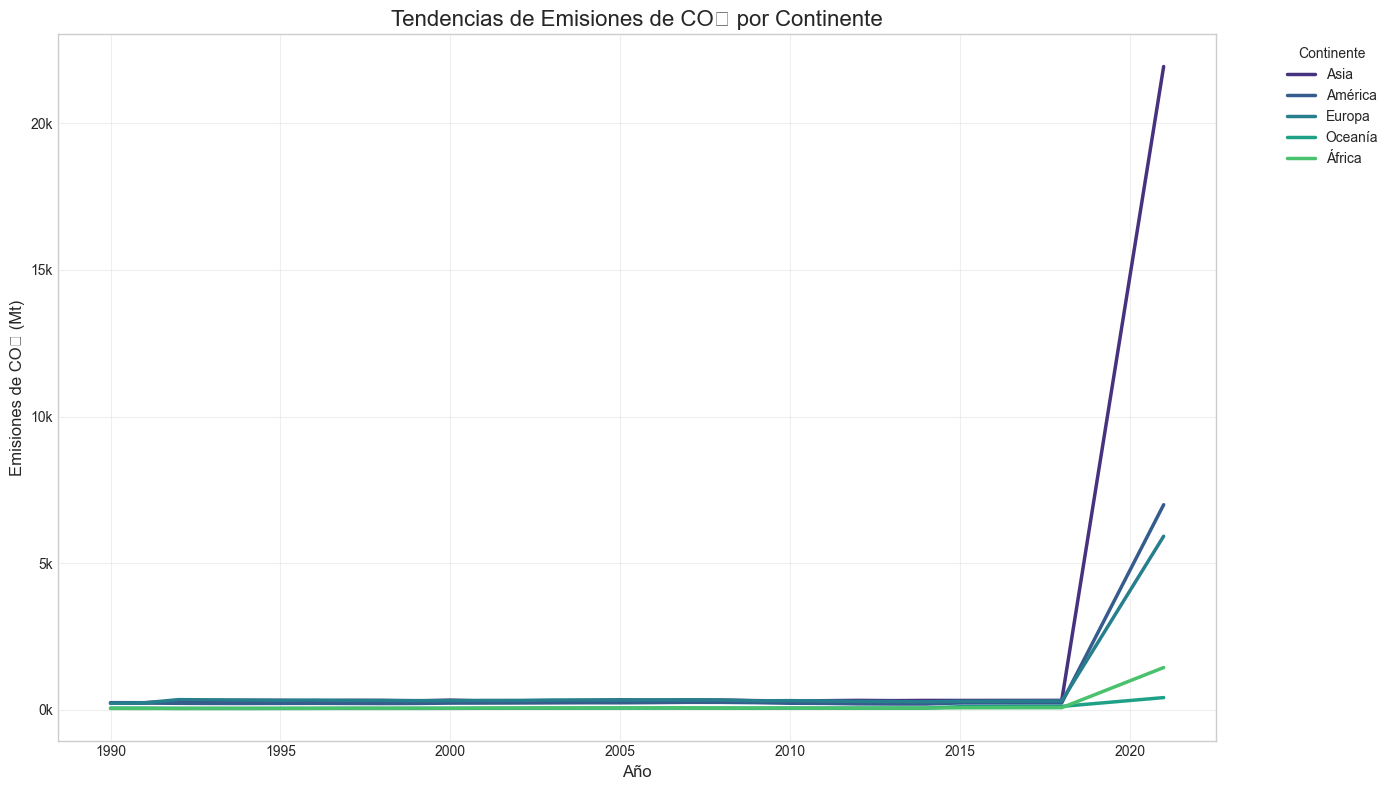

In [4]:
# Consulta para obtener emisiones por continente y año
query_continentes = """
SELECT 
    h.anio,
    c.nombre AS continente,
    SUM(h.valor) AS emisiones
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Subcontinentes s ON p.subcontinente_id = s.id
JOIN Continentes c ON s.continente_id = c.id
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'emision_co2'
GROUP BY h.anio, c.nombre
ORDER BY h.anio, emisiones DESC;
"""

df_continentes = pd.read_sql(query_continentes, conn)

# Crear gráfico de área apilada para emisiones por continente
plt.figure(figsize=(14, 8))

# Pivotear datos para el gráfico de área
df_pivot = df_continentes.pivot(index='anio', columns='continente', values='emisiones').fillna(0)

# Crear gráfico de área apilada
df_pivot.plot.area(stacked=True, alpha=0.7, figsize=(14, 8))

# Formatear eje y en millones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_millones))

plt.xlabel('Año', fontsize=12)
plt.ylabel('Emisiones de CO₂ (Mt)', fontsize=12)
plt.title('Evolución de Emisiones de CO₂ por Continente', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='Continente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Crear gráfico de líneas para comparar tendencias por continente
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_continentes, x='anio', y='emisiones', hue='continente', linewidth=2.5)

# Formatear eje y en millones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_millones))

plt.xlabel('Año', fontsize=12)
plt.ylabel('Emisiones de CO₂ (Mt)', fontsize=12)
plt.title('Tendencias de Emisiones de CO₂ por Continente', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='Continente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4. Top 15 Países Emisores

Identificamos los principales países emisores de CO₂ y analizamos su evolución.

C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\40364669.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_paises = pd.read_sql(query_top_paises, conn)
C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\40364669.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_paises, y='pais', x='emisiones', palette='viridis')
C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\40364669.py:33: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canv

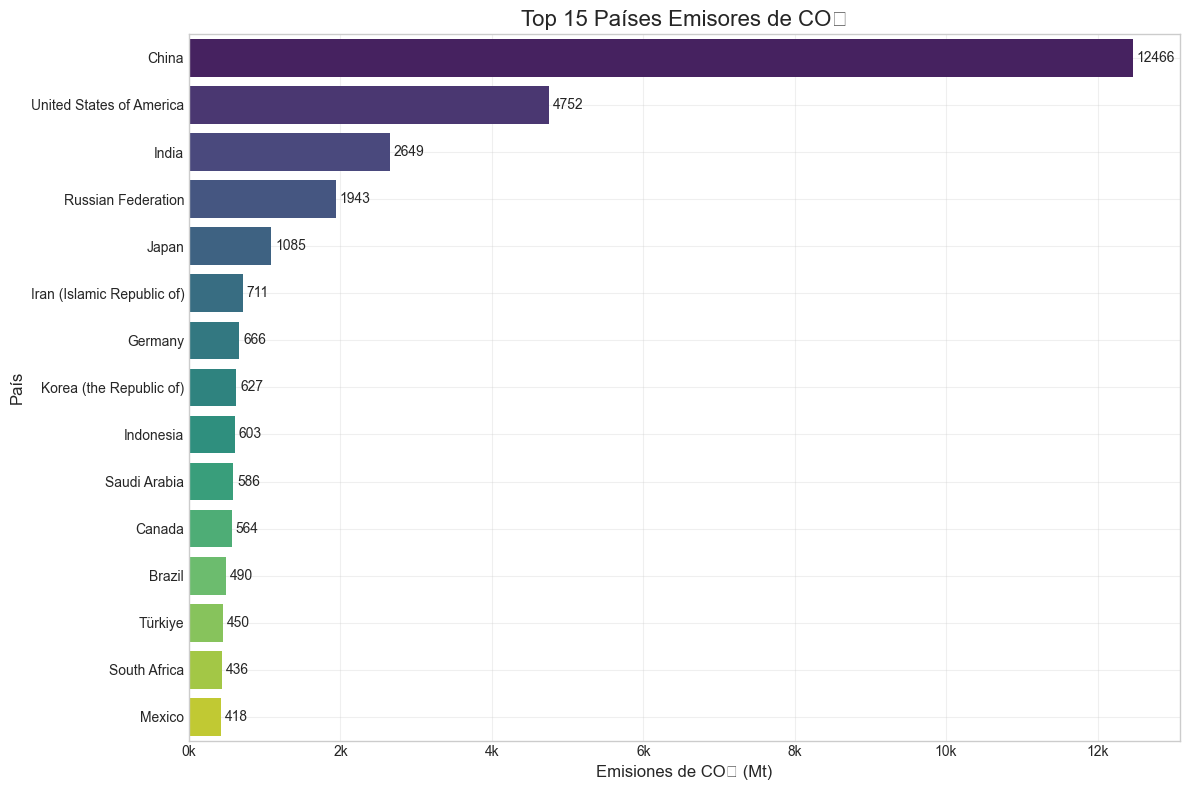

C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\40364669.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_evolucion_top = pd.read_sql(query_evolucion_top, conn, params=top5_paises)
C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\40364669.py:67: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


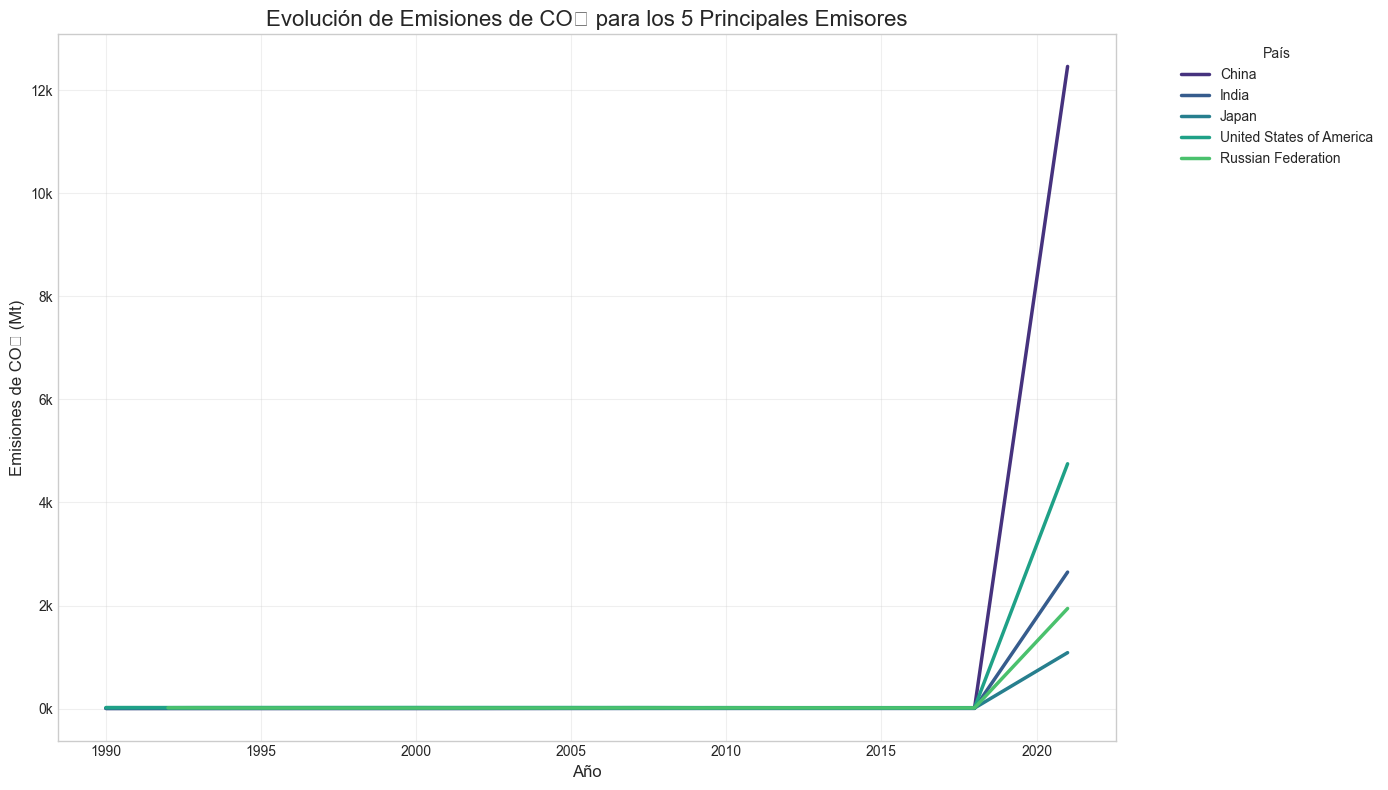

In [5]:
# Consulta para obtener los 15 principales países emisores en el año más reciente
query_top_paises = """
SELECT 
    p.nombre_en AS pais,
    p.codigo AS codigo_pais,
    h.valor AS emisiones
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'emision_co2'
AND h.anio = (SELECT MAX(anio) FROM Hechos WHERE indicador_id = i.id)
ORDER BY emisiones DESC
LIMIT 15;
"""

df_top_paises = pd.read_sql(query_top_paises, conn)

# Crear gráfico de barras horizontales para los principales emisores
plt.figure(figsize=(12, 8))
sns.barplot(data=df_top_paises, y='pais', x='emisiones', palette='viridis')

# Formatear eje x en millones
plt.gca().xaxis.set_major_formatter(FuncFormatter(formato_millones))

# Añadir etiquetas con valores
for i, v in enumerate(df_top_paises['emisiones']):
    plt.text(v + 50, i, f'{v:.0f}', va='center')

plt.xlabel('Emisiones de CO₂ (Mt)', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.title('Top 15 Países Emisores de CO₂', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Consulta para obtener la evolución de los 5 principales emisores
top5_paises = df_top_paises['codigo_pais'].head(5).tolist()

placeholders = ', '.join(['%s'] * len(top5_paises))
query_evolucion_top = f"""
SELECT 
    h.anio,
    p.nombre_en AS pais,
    h.valor AS emisiones
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'emision_co2'
AND p.codigo IN ({placeholders})
ORDER BY h.anio;
"""

df_evolucion_top = pd.read_sql(query_evolucion_top, conn, params=top5_paises)

# Crear gráfico de líneas para la evolución de los principales emisores
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_evolucion_top, x='anio', y='emisiones', hue='pais', linewidth=2.5)

# Formatear eje y en millones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_millones))

plt.xlabel('Año', fontsize=12)
plt.ylabel('Emisiones de CO₂ (Mt)', fontsize=12)
plt.title('Evolución de Emisiones de CO₂ para los 5 Principales Emisores', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Relación entre PIB y Emisiones de CO₂

Analizamos la correlación entre el desarrollo económico (PIB) y las emisiones de CO₂.

C:\Users\jcall\AppData\Local\Temp\ipykernel_18528\2875950022.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pib_co2 = pd.read_sql(query_pib_co2, conn)


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


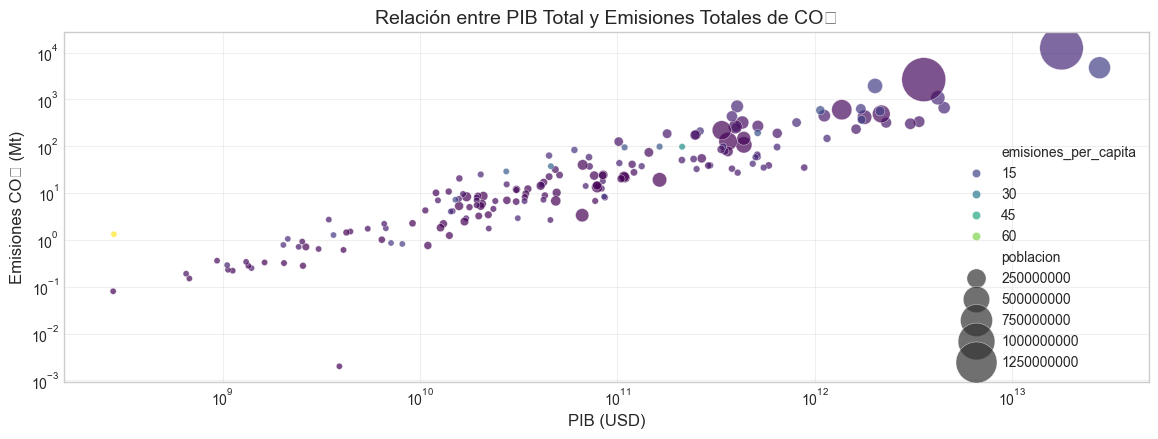

In [6]:
# Consulta para obtener PIB y emisiones de CO₂ para el año más reciente
query_pib_co2 = """
WITH ranked AS (
  SELECT
    h.pais_id,
    p.nombre_en AS pais,
    i.codigo AS indicador,
    h.valor,
    ROW_NUMBER() OVER (
      PARTITION BY h.pais_id, h.indicador_id
      ORDER BY h.anio DESC
    ) AS rn
  FROM Hechos h
  JOIN Paises p    ON h.pais_id      = p.codigo
  JOIN Indicadores i ON h.indicador_id = i.id
  WHERE i.codigo IN (
    'NY.GDP.MKTP.CD', 
    'emision_co2', 
    'SP.POP.TOTL'
  )
)
SELECT
  pais,
  pais_id AS codigo_pais,
  MAX(CASE WHEN indicador = 'NY.GDP.MKTP.CD' THEN valor END)    AS pib,
  MAX(CASE WHEN indicador = 'emision_co2' THEN valor END)      AS emisiones_co2,
  MAX(CASE WHEN indicador = 'SP.POP.TOTL' THEN valor END)      AS poblacion
FROM ranked
WHERE rn = 1
GROUP BY pais, codigo_pais
HAVING pib IS NOT NULL
   AND emisiones_co2 IS NOT NULL
   AND poblacion IS NOT NULL
ORDER BY pib DESC;
"""

df_pib_co2 = pd.read_sql(query_pib_co2, conn)

# Calcular emisiones per cápita y PIB per cápita
df_pib_co2['emisiones_per_capita'] = df_pib_co2['emisiones_co2'] * 1000000 / df_pib_co2['poblacion']
df_pib_co2['pib_per_capita'] = df_pib_co2['pib'] / df_pib_co2['poblacion']

# Crear gráfico de dispersión para PIB vs Emisiones
plt.figure(figsize=(14, 10))

# Gráfico 1: PIB total vs Emisiones totales
plt.subplot(2, 1, 1)
sns.scatterplot(
    data=df_pib_co2,
    x='pib',
    y='emisiones_co2',
    size='poblacion',
    sizes=(20, 1000),
    alpha=0.7,
    hue='emisiones_per_capita',
    palette='viridis'
)

# Añadir etiquetas para países destacados
paises_destacados = ['USA', 'CHN', 'IND', 'DEU', 'JPN', 'RUS', 'BRA', 'GBR', 'FRA', 'ESP']
for idx, row in df_pib_co2[df_pib_co2['codigo_pais'].isin(paises_destacados)].iterrows():
    plt.annotate(row['codigo_pais'], 
                xy=(row['pib'], row['emisiones_co2']), 
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('PIB (USD)', fontsize=12)
plt.ylabel('Emisiones CO₂ (Mt)', fontsize=12)
plt.title('Relación entre PIB Total y Emisiones Totales de CO₂', fontsize=14)
plt.grid(True, alpha=0.3)

# Añadir barra de color para emisiones per cápita
cbar = plt.colorbar()
cbar.set_label('Emisiones CO₂ per cápita (t/persona)', fontsize=10)

# Gráfico 2: PIB per cápita vs Emisiones per cápita
plt.subplot(2, 1, 2)
sns.scatterplot(
    data=df_pib_co2,
    x='pib_per_capita',
    y='emisiones_per_capita',
    size='poblacion',
    sizes=(20, 1000),
    alpha=0.7,
    hue='emisiones_per_capita',
    palette='viridis'
)

# Añadir línea de tendencia
x = df_pib_co2['pib_per_capita']
y = df_pib_co2['emisiones_per_capita']
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(x[mask]), y[mask])

# Añadir anotación con coeficiente de correlación
plt.annotate(f'Correlación: {r_value:.2f}', 
            xy=(0.75, 0.9), 
            xycoords='axes fraction',
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Añadir etiquetas para países destacados
for idx, row in df_pib_co2[df_pib_co2['codigo_pais'].isin(paises_destacados)].iterrows():
    plt.annotate(row['codigo_pais'], 
                xy=(row['pib_per_capita'], row['emisiones_per_capita']), 
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold')

plt.xscale('log')
plt.xlabel('PIB per cápita (USD/persona)', fontsize=12)
plt.ylabel('Emisiones CO₂ per cápita (t/persona)', fontsize=12)
plt.title('Relación entre PIB per Cápita y Emisiones per Cápita de CO₂', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Intensidad de Carbono de las Economías

Analizamos la eficiencia de carbono de las economías (emisiones por unidad de PIB) y su evolución.

In [ ]:
# Consulta para obtener datos históricos de PIB y emisiones para países seleccionados
paises_analisis = ['USA', 'CHN', 'DEU', 'IND', 'JPN', 'BRA', 'ESP', 'GBR']

placeholders = ', '.join(['%s'] * len(paises_analisis))
query_intensidad = f"""
SELECT 
    h.anio,
    p.codigo AS codigo_pais,
    p.nombre_en AS pais,
    i.codigo AS indicador,
    h.valor
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE p.codigo IN ({placeholders})
AND i.codigo IN ('emision_co2', 'NY.GDP.MKTP.CD')
ORDER BY p.codigo, h.anio;
"""

df_intensidad = pd.read_sql(query_intensidad, conn, params=paises_analisis)

# Pivotar datos para facilitar el cálculo de intensidad de carbono
df_pivot = df_intensidad.pivot_table(
    index=['anio', 'codigo_pais', 'pais'], 
    columns='indicador', 
    values='valor'
).reset_index()

# Calcular intensidad de carbono (kg CO₂ por USD de PIB)
df_pivot['intensidad_carbono'] = df_pivot['emision_co2'] * 1e6 / df_pivot['NY.GDP.MKTP.CD']

# Crear gráfico de evolución de intensidad de carbono
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_pivot, x='anio', y='intensidad_carbono', hue='pais', linewidth=2.5)

plt.xlabel('Año', fontsize=12)
plt.ylabel('Intensidad de Carbono (kg CO₂/USD)', fontsize=12)
plt.title('Evolución de la Intensidad de Carbono por País', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calcular la reducción porcentual de intensidad de carbono
df_cambio = df_pivot.groupby('pais').apply(lambda x: {
    'intensidad_inicial': x.loc[x['anio'] == x['anio'].min(), 'intensidad_carbono'].values[0],
    'intensidad_final': x.loc[x['anio'] == x['anio'].max(), 'intensidad_carbono'].values[0],
    'cambio_porcentual': (x.loc[x['anio'] == x['anio'].max(), 'intensidad_carbono'].values[0] / 
                         x.loc[x['anio'] == x['anio'].min(), 'intensidad_carbono'].values[0] - 1) * 100,
    'anio_inicial': x['anio'].min(),
    'anio_final': x['anio'].max()
}).apply(pd.Series)

# Mostrar tabla de cambios
print("Cambio en la intensidad de carbono por país:")
df_cambio = df_cambio.sort_values('cambio_porcentual')
print(df_cambio[['intensidad_inicial', 'intensidad_final', 'cambio_porcentual', 'anio_inicial', 'anio_final']])

## 7. Análisis de Correlación entre Indicadores Económicos y Emisiones

Examinamos las correlaciones entre diferentes indicadores económicos y las emisiones de CO₂.

In [ ]:
# Consulta para obtener múltiples indicadores económicos y emisiones
query_indicadores = """
SELECT 
    p.nombre_en AS pais,
    MAX(CASE WHEN i.codigo = 'emision_co2' THEN h.valor ELSE NULL END) AS emisiones_co2,
    MAX(CASE WHEN i.codigo = 'NY.GDP.MKTP.CD' THEN h.valor ELSE NULL END) AS pib,
    MAX(CASE WHEN i.codigo = 'SP.POP.TOTL' THEN h.valor ELSE NULL END) AS poblacion,
    MAX(CASE WHEN i.codigo = 'EG.ELC.FOSL.ZS' THEN h.valor ELSE NULL END) AS energia_fosil,
    MAX(CASE WHEN i.codigo = 'EG.ELC.RNEW.ZS' THEN h.valor ELSE NULL END) AS energia_renovable
FROM Hechos h
JOIN Paises p ON h.pais_id = p.codigo
JOIN Indicadores i ON h.indicador_id = i.id
WHERE i.codigo IN ('emision_co2', 'NY.GDP.MKTP.CD', 'SP.POP.TOTL', 'EG.ELC.FOSL.ZS', 'EG.ELC.RNEW.ZS')
AND h.anio >= 2015
GROUP BY p.nombre_en
HAVING emisiones_co2 IS NOT NULL AND pib IS NOT NULL AND poblacion IS NOT NULL;
"""

df_indicadores = pd.read_sql(query_indicadores, conn)

# Calcular indicadores derivados
df_indicadores['emisiones_per_capita'] = df_indicadores['emisiones_co2'] * 1000000 / df_indicadores['poblacion']
df_indicadores['pib_per_capita'] = df_indicadores['pib'] / df_indicadores['poblacion']
df_indicadores['intensidad_carbono'] = df_indicadores['emisiones_co2'] * 1000000 / df_indicadores['pib']

# Seleccionar columnas para la matriz de correlación
cols_correlacion = ['emisiones_co2', 'pib', 'poblacion', 'energia_fosil', 'energia_renovable',
                    'emisiones_per_capita', 'pib_per_capita', 'intensidad_carbono']

# Calcular matriz de correlación
corr_matrix = df_indicadores[cols_correlacion].corr()

# Crear mapa de calor de correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Matriz de Correlación entre Indicadores Económicos y Emisiones', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Proyecciones y Escenarios Futuros

Realizamos proyecciones simples de emisiones basadas en tendencias históricas.

In [ ]:
# Usar datos globales para proyección
df_proyeccion = df_global.copy()

# Crear modelo de regresión lineal simple
x = df_proyeccion['anio']
y = df_proyeccion['emisiones_totales']

# Ajustar modelo
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Crear años futuros para proyección
anio_max = df_proyeccion['anio'].max()
anios_futuros = np.arange(anio_max + 1, anio_max + 21)

# Proyectar emisiones
emisiones_proyectadas = p(anios_futuros)

# Crear DataFrame con proyecciones
df_futuro = pd.DataFrame({
    'anio': anios_futuros,
    'emisiones_totales': emisiones_proyectadas
})

# Concatenar datos históricos y proyecciones
df_completo = pd.concat([df_proyeccion, df_futuro])

# Crear gráfico con proyecciones
plt.figure(figsize=(14, 8))

# Datos históricos
sns.lineplot(data=df_proyeccion, x='anio', y='emisiones_totales', 
             linewidth=3, color='#1f77b4', label='Datos históricos')

# Proyección
sns.lineplot(data=df_futuro, x='anio', y='emisiones_totales', 
             linewidth=3, color='red', linestyle='--', label='Proyección lineal')

# Escenario de reducción moderada (1% anual)
df_reduccion_moderada = pd.DataFrame({
    'anio': anios_futuros,
    'emisiones_totales': [df_proyeccion['emisiones_totales'].iloc[-1] * (0.99 ** (i+1)) for i in range(len(anios_futuros))]
})

# Escenario de reducción agresiva (2.5% anual)
df_reduccion_agresiva = pd.DataFrame({
    'anio': anios_futuros,
    'emisiones_totales': [df_proyeccion['emisiones_totales'].iloc[-1] * (0.975 ** (i+1)) for i in range(len(anios_futuros))]
})

# Añadir escenarios alternativos
sns.lineplot(data=df_reduccion_moderada, x='anio', y='emisiones_totales', 
             linewidth=3, color='orange', linestyle='-.', label='Reducción moderada (1% anual)')
sns.lineplot(data=df_reduccion_agresiva, x='anio', y='emisiones_totales', 
             linewidth=3, color='green', linestyle=':', label='Reducción agresiva (2.5% anual)')

# Formatear eje y en millones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_millones))

plt.xlabel('Año', fontsize=12)
plt.ylabel('Emisiones Globales de CO₂ (Mt)', fontsize=12)
plt.title('Proyecciones de Emisiones Globales de CO₂ (2025-2045)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## 9. Conclusiones

A partir del análisis realizado, podemos extraer las siguientes conclusiones sobre las tendencias globales de emisiones de CO₂ y su relación con indicadores económicos:

1. **Tendencia global creciente**: Las emisiones globales de CO₂ han mostrado una tendencia creciente sostenida, con un incremento anual compuesto que refleja la continua dependencia de combustibles fósiles.

2. **Distribución geográfica desigual**: Asia ha emergido como el principal emisor, superando a América del Norte y Europa, principalmente debido al rápido desarrollo industrial de China e India.

3. **Correlación PIB-Emisiones**: Existe una fuerte correlación positiva entre el PIB y las emisiones totales de CO₂, aunque esta relación es más compleja a nivel per cápita.

4. **Mejora en eficiencia de carbono**: La intensidad de carbono (emisiones por unidad de PIB) ha disminuido en la mayoría de economías desarrolladas, indicando una mayor eficiencia energética y/o transición hacia fuentes menos intensivas en carbono.

5. **Divergencia entre economías**: Las economías emergentes muestran trayectorias de emisiones crecientes mientras que muchas economías desarrolladas han comenzado a estabilizar o reducir sus emisiones.

6. **Impacto de energías renovables**: Los países con mayor porcentaje de energía renovable tienden a mostrar menor intensidad de carbono, evidenciando el potencial de estas tecnologías para la descarbonización.

7. **Proyecciones preocupantes**: De continuar las tendencias actuales, las emisiones globales seguirán aumentando, alejándonos de los objetivos climáticos internacionales. Se requieren reducciones significativas y sostenidas para revertir esta tendencia.

8. **Relación de produccion de co2 - pib**: Como se puede observar en los mapas regionales obtenidos en el apartado 0, se aprefcia que los paises como mayor PIB son aparentemente los que mas emisiones de CO2 producen, salvo excepciones, asi como los paises menos desarrollados de Africa pposeen un ratio de emisiones de co2 - PIB cercano al 0.0

Estos hallazgos subrayan la necesidad de políticas climáticas ambiciosas y diferenciadas según el nivel de desarrollo económico de cada país, así como una aceleración en la transición energética global.

In [ ]:
# Cerrar conexión a la base de datos
conn.close()